# Ноябрь 2017

# OTP Bank Contest
## Описание задачи

Один из способов повышения эффективности взаимодействия банка с клиентами заключается в том, чтобы отправлять предложение о новой услуге не всем клиентам банка, а только некоторой части, выбираемой по принципу наибольшей склонности к отклику на данное предложение.

Конкурсное задание заключается в том, чтобы предложить алгоритм, который будет выдавать оценку склонности клиента к положительному отклику по его признаковому описанию. Эта оценка может (хотя и не обязана) интерпретироваться как вероятность положительного отклика. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем клиентам, у которых значение оценки выше некоторого порога.

Ссылка на конкурс:
http://poligon.machinelearning.ru/Contests/Card.aspx?synonim=otp

# Быстрое-перемещение

1. [Эксплоративный анализ](#Эксплоративный-анализ)
    1. [Загружаем данные](#Загружаем-данные)
    1. [Дополнительные функции](#Дополнительные-функции)
    1. [Описание полей](#Описание-полей)
    1. [Обрабатываем пропущенные значения](#Обрабатываем-пропущенные-значения)
    1. [Вывод о WORK_TIME](#Вывод-о-WORK_TIME)
    1. [Преобразуем численные значения](#Преобразуем-численные-значения)
    1. [Бининг](#Бининг)
    1. [Добавление фичей](#Добавление-фичей)
    1. [Обработка численных полей](#Обработка-численных-полей)  
      
1. [Data Processing Tool](#Data-Processing-Tool)
    1. [Первая версия](#Первая-версия)
    1. [Вторая версия](#Вторая-версия)
    1. [Построение RF без подгонки параметров](#Построение-RF-без-подгонки-параметров)
1. [Построение моделей](#Построение-моделей)

# Эксплоративный анализ
[Вернуться к быстрому перемещению](#Быстрое-перемещение)

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

from IPython.display import display
plt.rc('font', family='Verdana')

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split

from sklearn.tree import _tree

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [3]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Загружаем данные

In [4]:
data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep = ';')
data.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,0,1,220,18.0000,0,0,1,1,1,6,2,1,1580,1580,nan
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,0,1,137,97.0000,1,0,1,1,1,6,1,1,4020,4020,nan
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,0,1,251,84.0000,0,0,1,2,1,11,0,0,0,0,nan
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,0,36,168.0000,1,1,1,1,1,6,3,1,"1589,923333",1590,nan
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,0,1,83,101.0000,1,0,1,2,1,16,2,1,"1152,15",2230,nan


## Дополнительные функции

In [5]:
def small_categories_aggregation(column, n_samples, value='Укрупненная категория', dataset=data):
    '''
    Укрупняет категории и числовые столбцы в датасете
    :param column: имя стоблца в датасете data
    :param n_samples: порог наблюдений, ниже которого категории объединяются в одну
    :param value: значение, которым будет заполнено
    :param dataset: датасет для изменения
    :return:
    '''

    tmp_small_columns = dataset[column].value_counts()[dataset[column].value_counts() < n_samples].index

    for col in tmp_small_columns:
        dataset.at[dataset[column] == col, column] = value
        
        
def show_columns_with_missing(dataset=data):
    '''
    показать столбцы, где есть пропущенные значения
    :param dataset: датасет
    :return:
    '''
    
    miss_columns = dataset.count(axis=0)[dataset.count(axis=0) < len(dataset)].index

    for i in miss_columns:
        print(dataset.isnull()[i].value_counts())
        print()

    display(miss_columns)
    

def columns(dataset=data):
    
    categorical_columns = [col for col in dataset.columns if dataset[col].dtype.name == 'object']
    numerical_columns = [col for col in dataset.columns if dataset[col].dtype.name != 'object']
    
    return categorical_columns, numerical_columns
    

cat_columns, num_columns = columns()
    
    
def show_binning(dataset=data, categorical_columns=cat_columns):

    columns_to_enlargment = []

    for column in categorical_columns:
        if dataset[column].value_counts().values[-1] < len(dataset)/100:
            columns_to_enlargment.append(column)
            print(dataset[column].value_counts())
            print()
            
    return columns_to_enlargment


# Пишем функцию, которая вычисляет глубину терминальных 
# узлов в отдельном дереве
def leaf_depths(tree, node_id = 0):

    '''
    tree.children_left и tree.children_right записывают идентификационные
    номера левого и правого узлов-потомков для данного узла
    '''

    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    '''
    Если данный узел является терминальным, 
    то оба дочерних узла будут иметь значение _tree.TREE_LEAF,
    что позволяет нам проверить, является ли данный узел терминальным
    '''

    if left_child == _tree.TREE_LEAF:
      
       '''
       Задать глубину терминальных узлов равной 0
       '''
      
       depths = np.array([0])

    else:
     
        '''
        Получить значения глубины узлов-потомков
        и увеличить их на 1
        '''
        
        left_depths = leaf_depths(tree, left_child) + 1
        right_depths = leaf_depths(tree, right_child) + 1
 
        depths = np.append(left_depths, right_depths)
 
    return depths


# Пишем функцию, которая вычисляет минимальное количество наблюдений 
# в терминальных узлах отдельного дерева
def leaf_samples(tree, node_id = 0):
    
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    if left_child == _tree.TREE_LEAF:
        
         samples = np.array([tree.n_node_samples[node_id]])

    else:
        
        left_samples = leaf_samples(tree, left_child)
        right_samples = leaf_samples(tree, right_child)

        samples = np.append(left_samples, right_samples)

    return samples


# Пишем функцию, которая строит гистограмму распределения 
# глубин терминальных узлов и гистограмму распределения 
# количества наблюдений в терминальных узлах по ансамблю
def draw_ensemble(ensemble):

    plt.figure(figsize=(16, 14))
    plt.subplot(211)

    depths_all = np.array([], dtype=int)

    for x in ensemble.estimators_:
        tree = x.tree_
        depths = leaf_depths(tree)
        depths_all = np.append(depths_all, depths)
        plt.hist(depths, histtype='step', color='#ddaaff', 
                 bins=range(min(depths), max(depths)+1))

    plt.hist(depths_all, histtype='step', color='#9933ff', 
             bins=range(min(depths_all), max(depths_all)+1), 
             weights=np.ones(len(depths_all))/len(ensemble.estimators_), 
             linewidth=2)
    plt.xlabel("Глубина терминальных узлов")
   
    samples_all = np.array([], dtype=int)
    
    plt.subplot(212)
    
    for x in ensemble.estimators_:
        tree = x.tree_
        samples = leaf_samples(tree)
        samples_all = np.append(samples_all, samples)
        plt.hist(samples, histtype='step', color='#aaddff', 
                 bins=range(min(samples), max(samples)+1))
    
    plt.hist(samples_all, histtype='step', color='#3399ff', 
             bins=range(min(samples_all), max(samples_all)+1), 
             weights=np.ones(len(samples_all))/len(ensemble.estimators_), 
             linewidth=2)
    plt.xlabel("Количество наблюдений в терминальных узлах")
    
    plt.show()

In [6]:
# указано в условии
data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)

# удаляем id
data.drop('AGREEMENT_RK', axis=1, inplace=True)

## Описание полей

In [7]:
pd.read_excel('data/Credit_OTP_columns_description.xls')

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,TARGET,целевая переменная:отклик на маркетинговую кам...
2,AGE,возраст клиента
3,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...
4,SOCSTATUS_PENS_FL,социальный статус клиента относительно пенсии ...
5,GENDER,"пол клиента (1 - мужчина, 0 - женщина)"
6,CHILD_TOTAL,количество детей клиента
7,DEPENDANTS,количество иждивенцев клиента
8,EDUCATION,образование
9,MARITAL_STATUS,семейное положение


In [8]:
categorical_columns = ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 'EDUCATION', 'MARITAL_STATUS', 
                       'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR',
                       'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE',
                       'REGION_NM', 'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL', 
                       'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
                       'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
                       'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL']

## Обрабатываем пропущенные значения

In [9]:
# уникальные значения
for i in data.columns:
    print(i)
    print(data[i].unique())
    print()

TARGET
[0 1]

AGE
[49 32 52 39 30 29 35 41 53 43 54 26 62 45 38 65 34 28 37 42 33 27 31 40
 63 61 44 59 48 24 23 47 58 51 56 22 36 57 50 46 55 66 25 60 64 21 67]

SOCSTATUS_WORK_FL
[1 0]

SOCSTATUS_PENS_FL
[0 1]

GENDER
[1 0]

CHILD_TOTAL
[ 2  3  4  1  0  5  6  7  8 10]

DEPENDANTS
[1 3 0 2 4 5 6 7]

EDUCATION
['Среднее специальное' 'Среднее' 'Неполное среднее' 'Высшее'
 'Неоконченное высшее' 'Два и более высших образования' 'Ученая степень']

MARITAL_STATUS
['Состою в браке' 'Гражданский брак' 'Разведен(а)' 'Не состоял в браке'
 'Вдовец/Вдова']

GEN_INDUSTRY
['Торговля' 'Информационные технологии' 'Образование'
 'Государственная служба' 'Другие сферы' 'Сельское хозяйство'
 'Здравоохранение' 'Металлургия/Промышленность/Машиностроение' nan
 'Коммунальное хоз-во/Дорожные службы' 'Строительство' 'Транспорт'
 'Банк/Финансы' 'Ресторанный бизнес/Общественное питание' 'Страхование'
 'Нефтегазовая промышленность' 'СМИ/Реклама/PR-агенства' 'Энергетика'
 'Салоны красоты и здоровья' 'ЧОП/Детектив

In [10]:
# одно уникальное значение, удаляем
data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

In [11]:
show_columns_with_missing()

False    13856
True      1367
Name: GEN_INDUSTRY, dtype: int64

False    13856
True      1367
Name: GEN_TITLE, dtype: int64

False    13856
True      1367
Name: ORG_TP_STATE, dtype: int64

False    13858
True      1365
Name: ORG_TP_FCAPITAL, dtype: int64

False    13856
True      1367
Name: JOB_DIR, dtype: int64

False    14928
True       295
Name: TP_PROVINCE, dtype: int64

False    15222
True         1
Name: REGION_NM, dtype: int64

False    13855
True      1368
Name: WORK_TIME, dtype: int64



Index(['GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL',
       'JOB_DIR', 'TP_PROVINCE', 'REGION_NM', 'WORK_TIME'],
      dtype='object')

In [12]:
# переводим в категориальные значения
for i in categorical_columns:
    if i in data.columns:
        data[i]=data[i].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 50 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null object
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDRE

In [13]:
show_columns_with_missing()

False    13855
True      1368
Name: WORK_TIME, dtype: int64



Index(['WORK_TIME'], dtype='object')

In [14]:
# если человек нигде не работает, то WORK_TIME = 0
data.at[(data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0

In [15]:
show_columns_with_missing()

False    15222
True         1
Name: WORK_TIME, dtype: int64



Index(['WORK_TIME'], dtype='object')

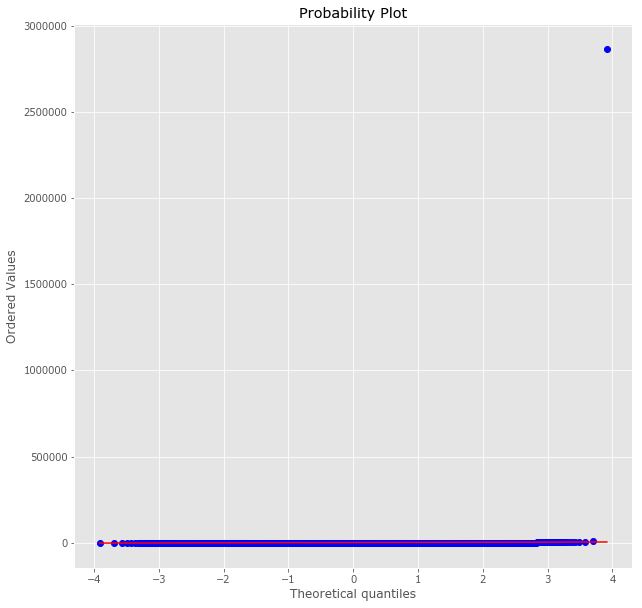

In [16]:
## QQ Plot для всех значений WORK_TIME
plt.subplots(figsize=(10, 10))

stats.probplot(data['WORK_TIME'].dropna().sort_values(), dist="norm", plot=plt)
plt.show()

In [17]:
# эспериментально выбранное значение
heu_const_work_time = 15200

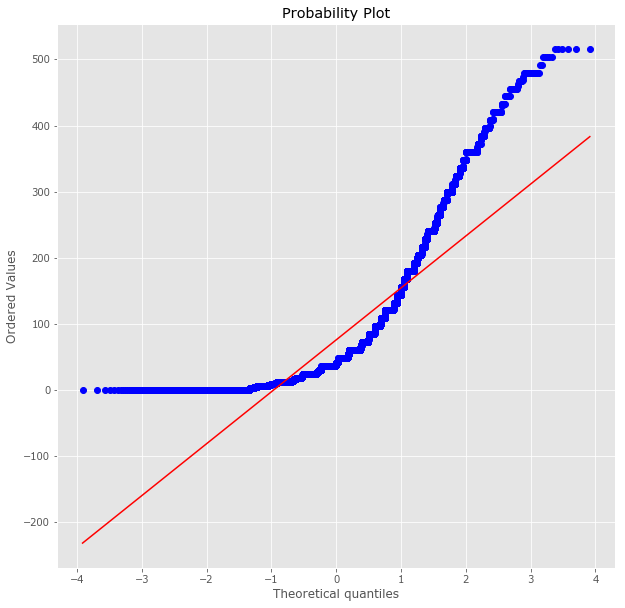

In [18]:
plt.subplots(figsize=(10, 10))

stats.probplot((data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time]), dist="norm", plot=plt)
plt.show()

### Распределения

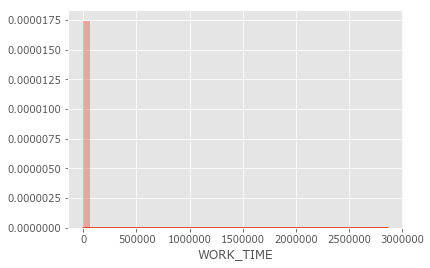

In [19]:
sns.distplot(data['WORK_TIME'].dropna().sort_values().dropna())

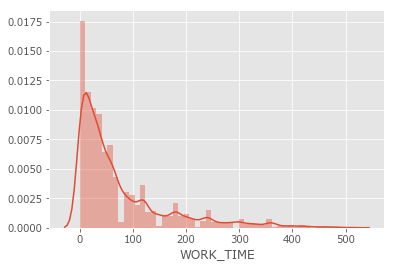

In [20]:
sns.distplot(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].dropna())

In [21]:
# максимальное значение, после которого значения считаются "неправильными"
maxy_work_time = max(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time])
maxy_work_time

516.0

In [22]:
# считаем значения больше maxy_work_time - пропущенными
data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN

# стало не слишком больше пропущенных значений
len(data['WORK_TIME']) - len(data['WORK_TIME'].dropna())

22

In [23]:
# значение медианы, не учитывающее замену некоторых пропущенных значений неработающих людей на 0
data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()

48.0

In [24]:
# аналогичное среднее
data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].mean()

83.04951568599104

median


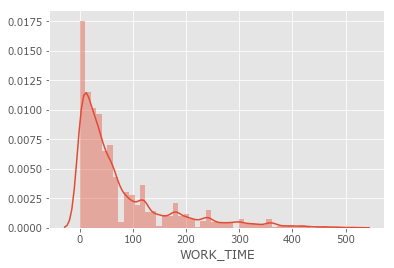

In [25]:
print('median')
sns.distplot(data['WORK_TIME'].fillna(data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()))

In [26]:
true_median = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
data['WORK_TIME'].fillna(true_median, inplace=True)

## Вывод о WORK_TIME
Для неработающих людей WORK_TIME заменили на ноль, было выявлено, что есть "неправильные" значения, то есть нельзя отработать 300 000 месяцев. Порог этих значений я определил по qq plot и выявил значение, больше которого значения считать правдивыми нельзя. Затем я заменил эти значения на пропуски и импутировал пропуски медианным значением WORK_TIME без учета 0 (неработающих) людей

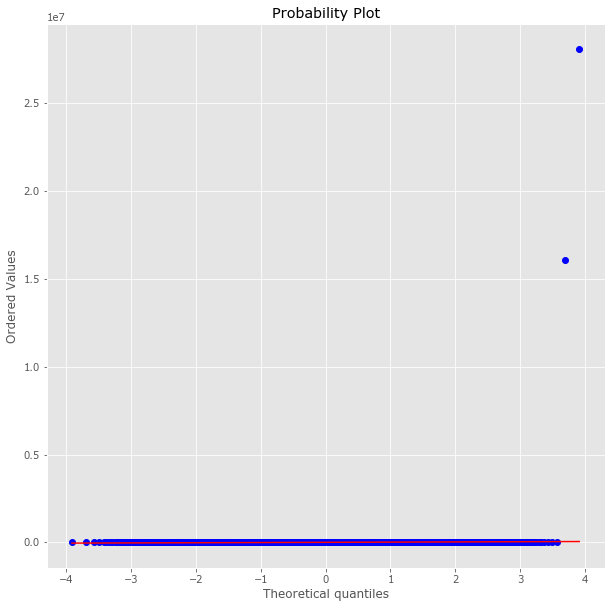

In [27]:
## QQ Plot
plt.subplots(figsize=(10, 10))

stats.probplot(data['FACT_LIVING_TERM'].dropna().sort_values(), dist="norm", plot=plt)
plt.show()

### Ситуация аналогична WORK_TIME

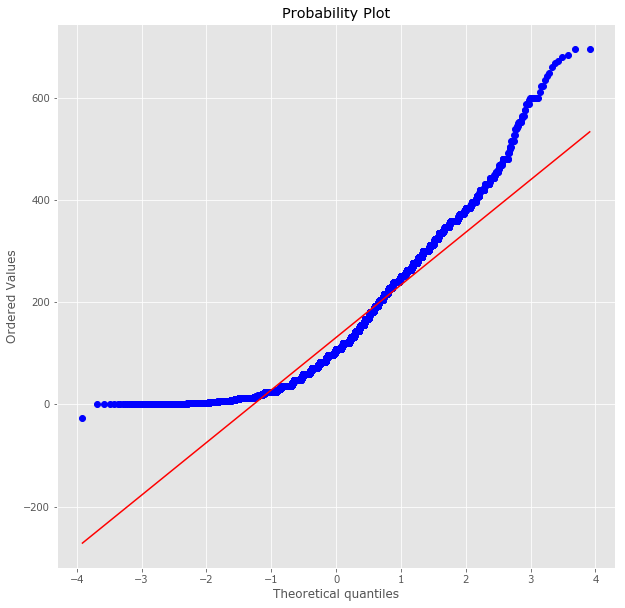

In [28]:
## QQ Plot
plt.subplots(figsize=(10, 10))

stats.probplot(data['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time], dist="norm", plot=plt)
plt.show()

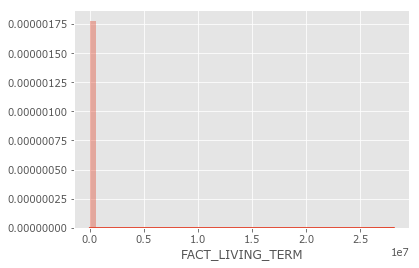

In [29]:
sns.distplot(data['FACT_LIVING_TERM'].dropna().sort_values())

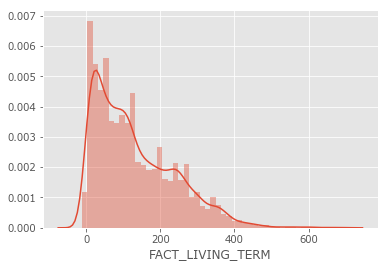

In [30]:
sns.distplot(data['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time])

In [31]:
data[data['FACT_LIVING_TERM'] < 0]

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
6246,0,56,1,0,1,0,0,Высшее,Состою в браке,Строительство,Высококвалифиц. специалист,Частная компания,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,23000,Приморский край,Приморский край,Приморский край,Приморский край,ДАЛЬНЕВОСТОЧНЫЙ,1,1,1,1,1,1,0,0,0,1,0,0,98136,24,40664,1,-26,288.0000,1,0,1,1,0,4,0,0,0,0,0.0000


In [32]:
data.at[data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0

In [33]:
maxy_live_term = max(data['FACT_LIVING_TERM'].sort_values()[:heu_const_work_time])

In [34]:
# считаем значения больше maxy_work_time - пропущенными
data.at[data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN

# стало не слишком больше пропущенных значений
len(data['FACT_LIVING_TERM']) - len(data['FACT_LIVING_TERM'].dropna())

23

median


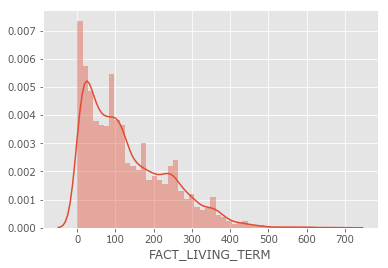

In [35]:
print('median')
sns.distplot(data['FACT_LIVING_TERM'].fillna(data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()))

In [36]:
true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)

## Преобразуем численные значения

In [37]:
for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
    if i in data.columns:
        data[i] = data[i].str.replace(',', '.').astype('float')

In [38]:
cat_columns, num_columns = columns()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 50 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null object
FACT_ADDR

In [39]:
data[cat_columns].describe()

,TARGET,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,GPF_DOCUMENT_FL,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL
count,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223
unique,2,2,2,2,7,5,32,13,6,3,11,5,81,81,80,71,12,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,0,1,0,1,Среднее специальное,Состою в браке,Торговля,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,Краснодарский край,Кемеровская область,Краснодарский край,Краснодарский край,ЮЖНЫЙ,1,1,1,1,1,0,0,0,0,0,0,1,1,0,1
freq,13411,13847,13176,9964,6518,9416,2385,7010,6523,13688,11452,7077,674,674,674,790,2179,12765,14480,13493,12758,13782,10507,14097,11940,15074,14930,14558,8961,9311,14389,13855


In [40]:
data[num_columns].describe()

,AGE,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,OWN_AUTO,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
count,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000
mean,40.4061,1.0994,0.6452,13853.8363,0.1163,14667.9593,8.1010,3398.5627,131.0020,75.5412,1.3878,0.7519,7.8760,0.1954,0.1302,239.4571,243.0216,0.0191
std,11.6011,0.9954,0.8123,9015.4676,0.3208,12147.8735,4.0941,5158.1089,107.6183,89.5994,0.7936,0.9885,7.9557,0.6850,0.3557,827.7004,836.1001,0.1377
min,21.0000,0.0000,0.0000,24.0000,0.0000,2000.0000,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,30.0000,0.0000,0.0000,8000.0000,0.0000,6500.0000,6.0000,1000.0000,41.0000,14.0000,1.0000,0.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,39.0000,1.0000,0.0000,12000.0000,0.0000,11550.0000,6.0000,2000.0000,107.0000,40.0000,1.0000,0.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,50.0000,2.0000,1.0000,17000.0000,0.0000,19170.0000,10.0000,4000.0000,204.0000,96.0000,2.0000,1.0000,8.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,67.0000,10.0000,7.0000,250000.0000,2.0000,119700.0000,36.0000,140000.0000,696.0000,516.0000,11.0000,11.0000,114.0000,13.0000,8.0000,28012.2000,28012.2000,2.0000


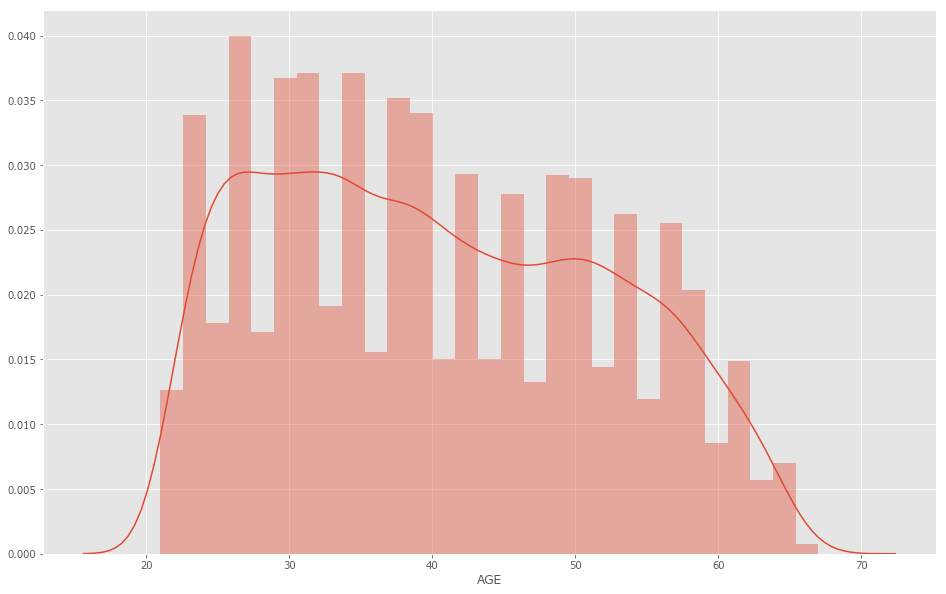

In [41]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[0]])

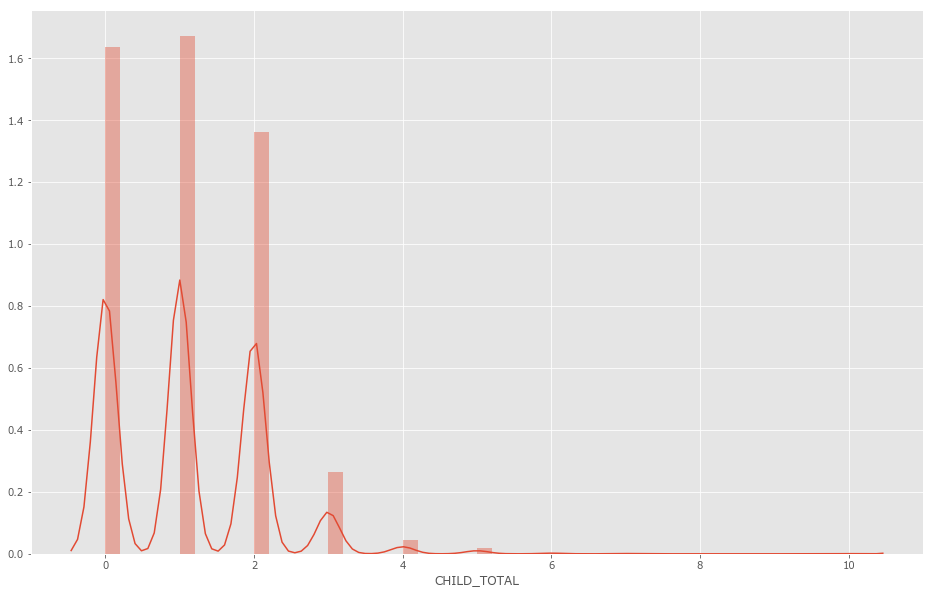

In [42]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[1]])

### Явно видно, что CHILD_TOTAL скорее категориальная переменная

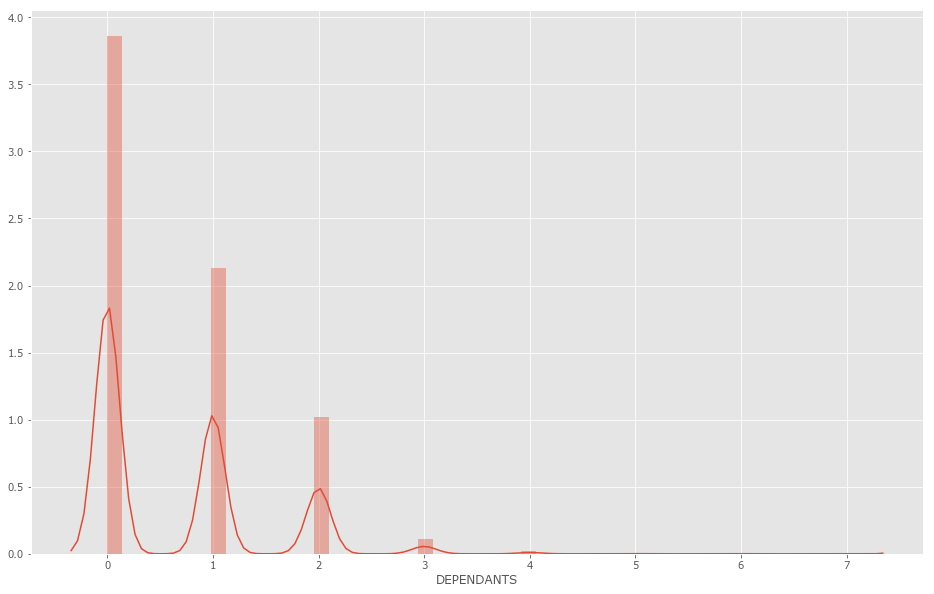

In [43]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[2]])

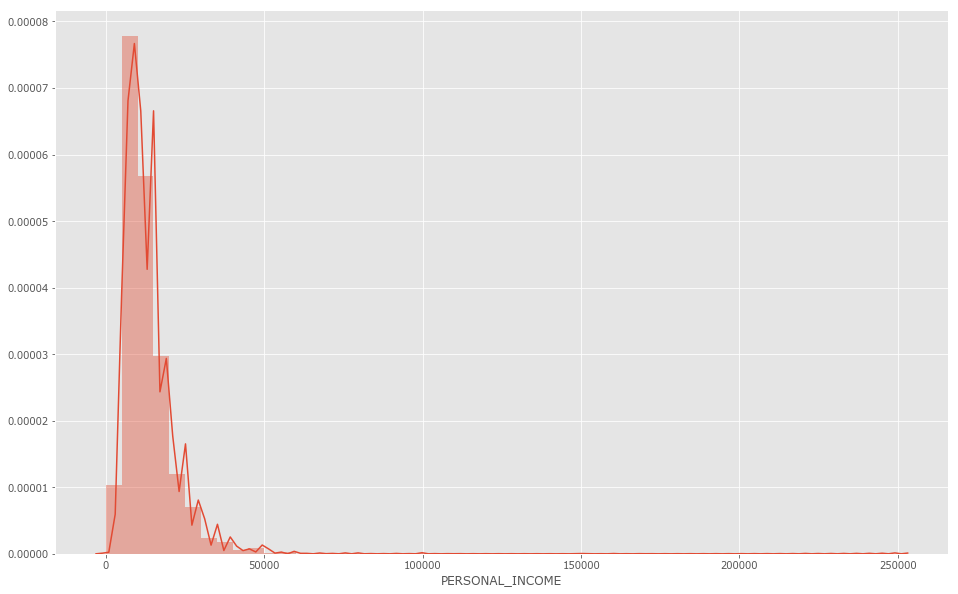

In [44]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[3]])

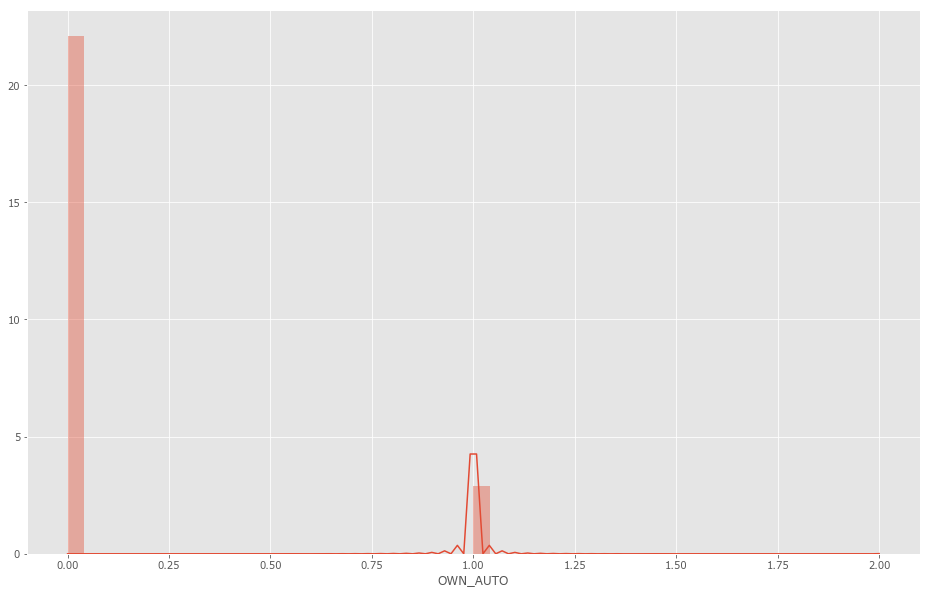

In [45]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[4]])

In [46]:
data['OWN_AUTO'].value_counts()

0    13453
1     1769
2        1
Name: OWN_AUTO, dtype: int64

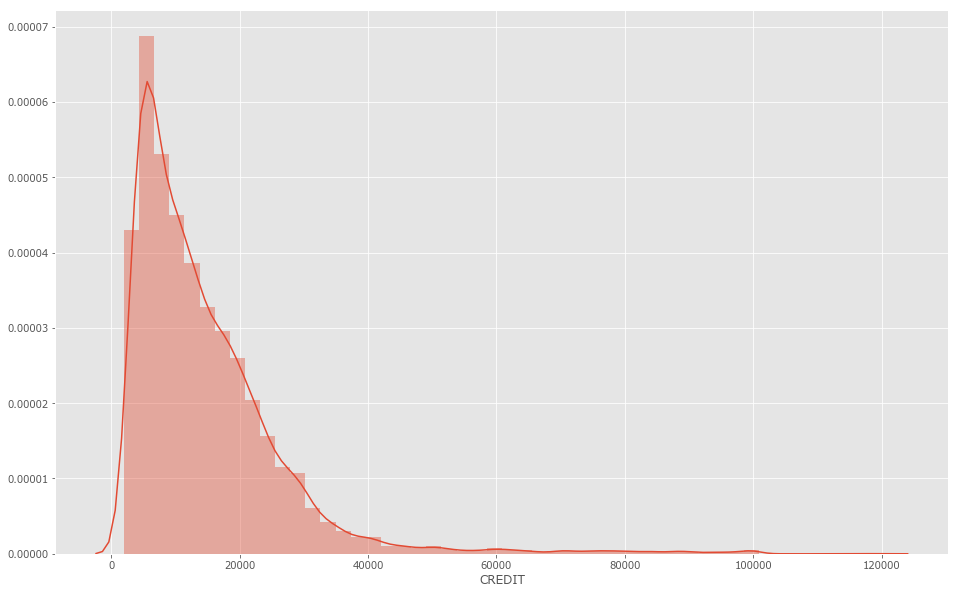

In [47]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[5]])

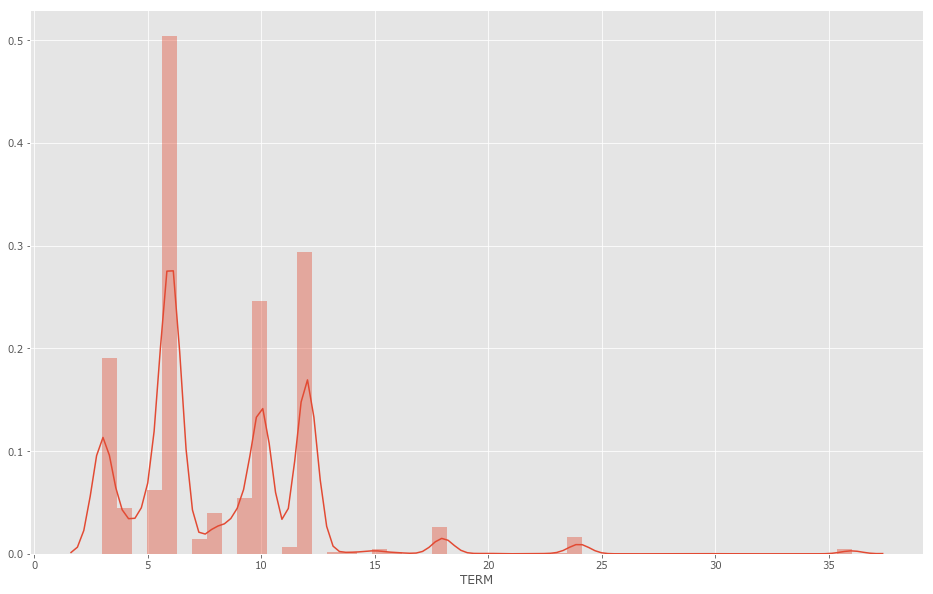

In [48]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[6]])

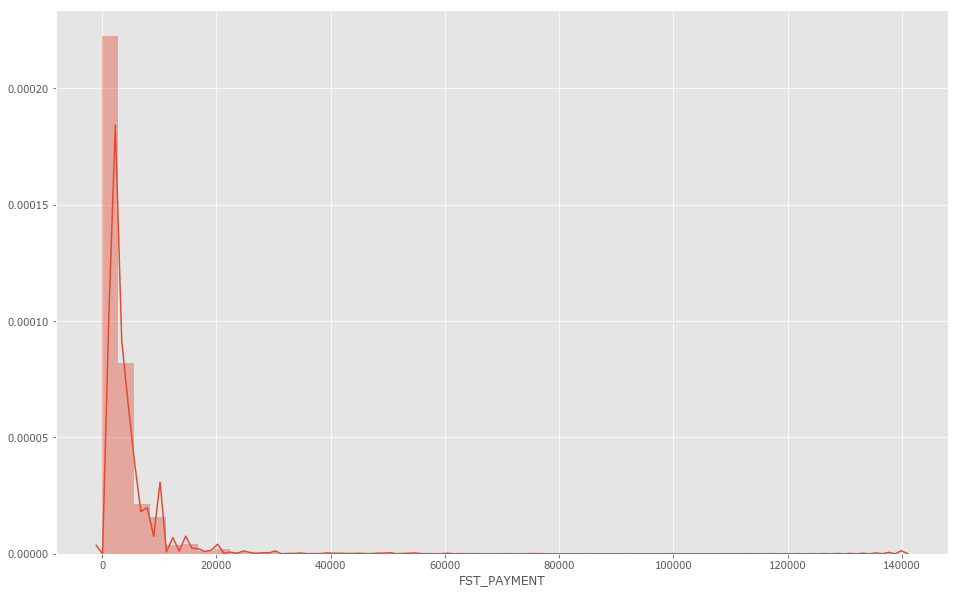

In [49]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[7]])

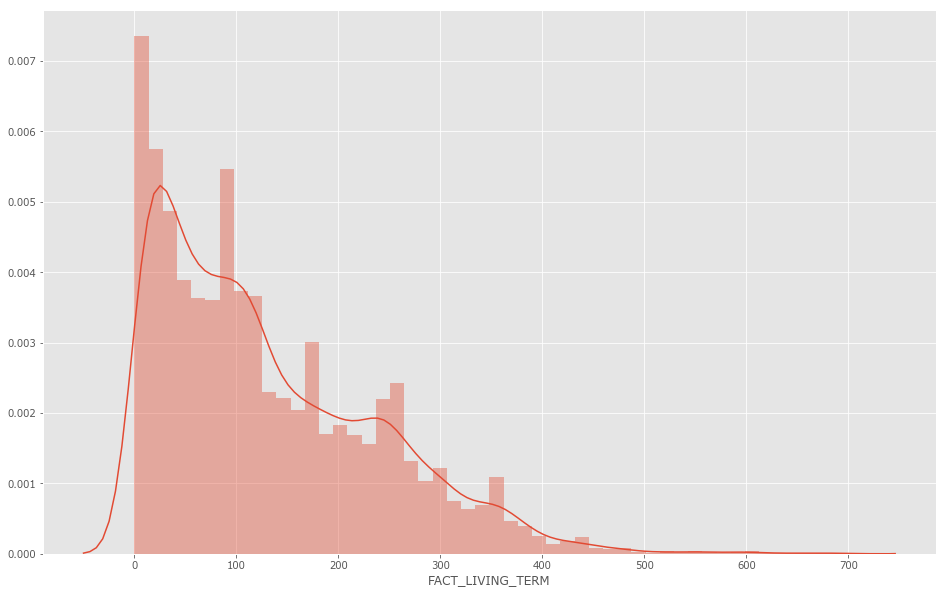

In [50]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[8]])

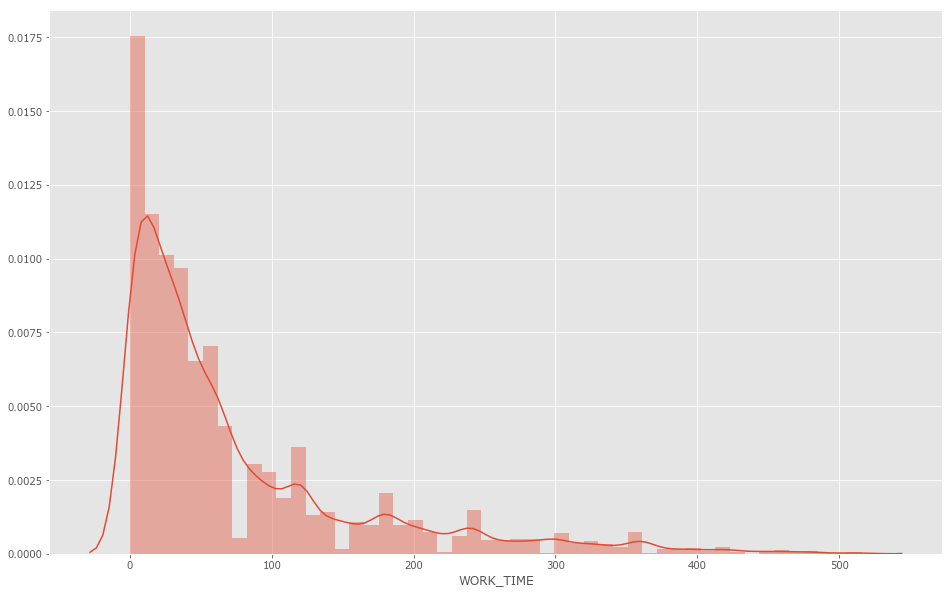

In [51]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[9]])

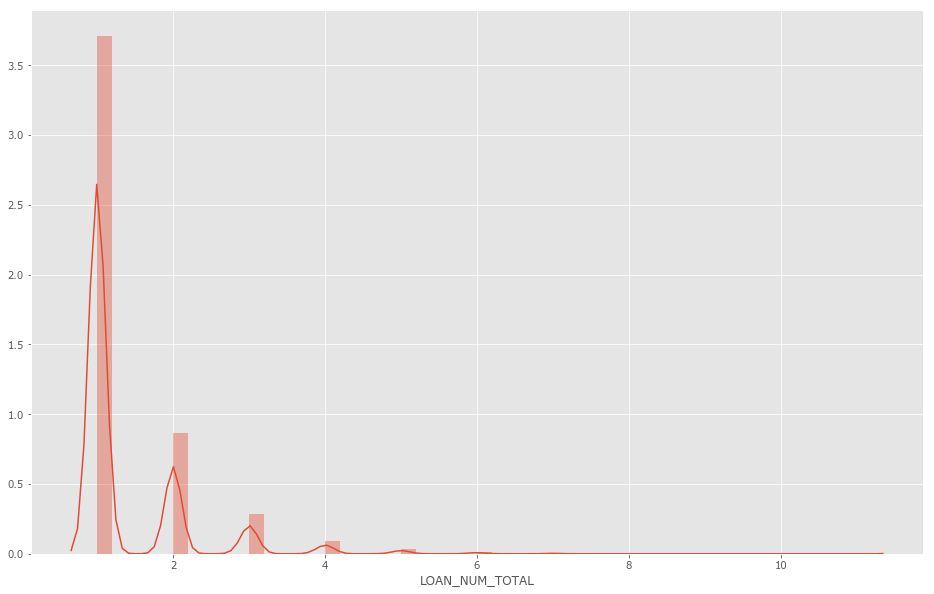

In [52]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[10]])

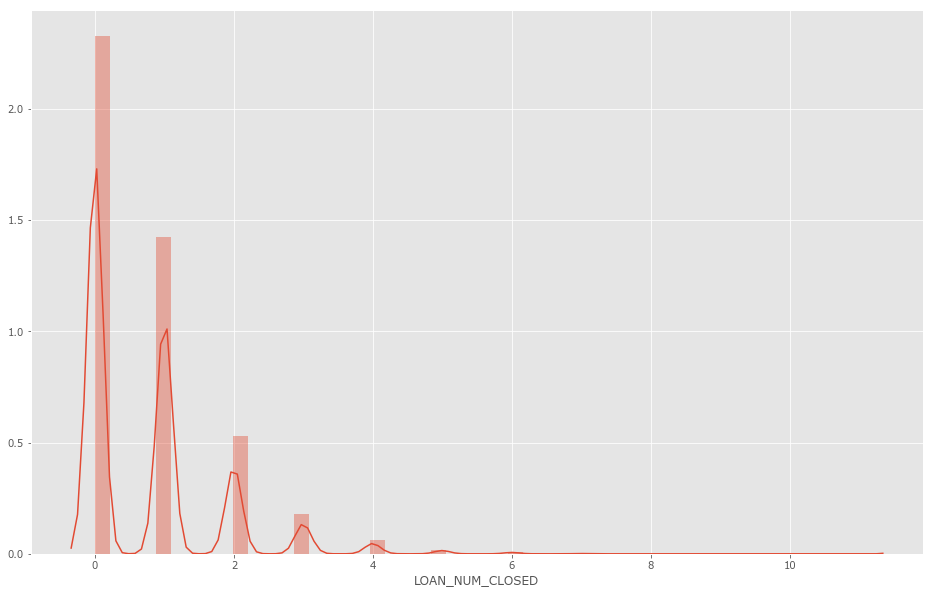

In [53]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[11]])

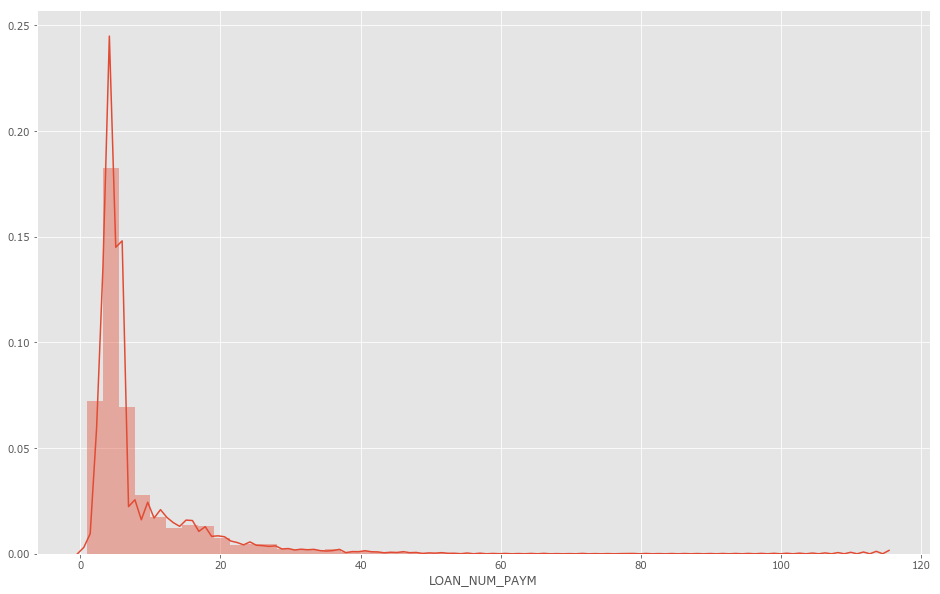

In [54]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[12]])

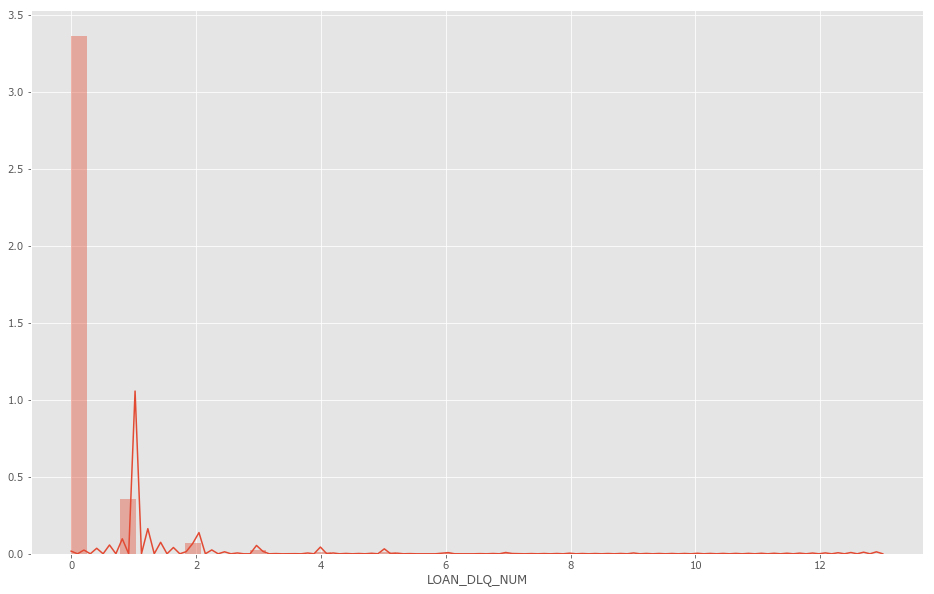

In [55]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[13]])

In [56]:
data['LOAN_DLQ_NUM'].value_counts()

0     13301
1      1416
2       280
3        96
4        48
5        39
6        16
7        14
9         4
8         3
13        2
10        2
12        1
11        1
Name: LOAN_DLQ_NUM, dtype: int64

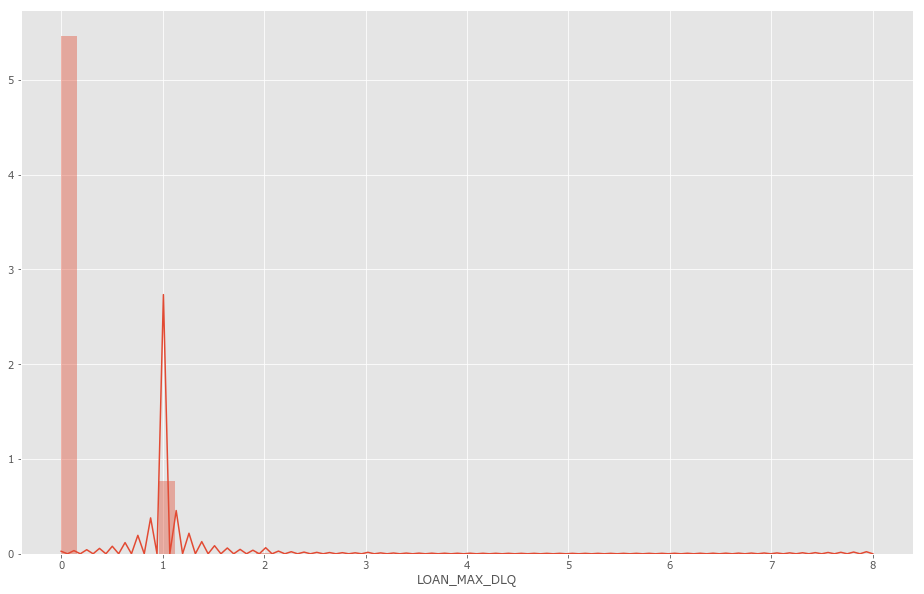

In [57]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[14]])

In [58]:
data['LOAN_MAX_DLQ'].value_counts()

0    13301
1     1881
2       31
3        7
6        1
4        1
8        1
Name: LOAN_MAX_DLQ, dtype: int64

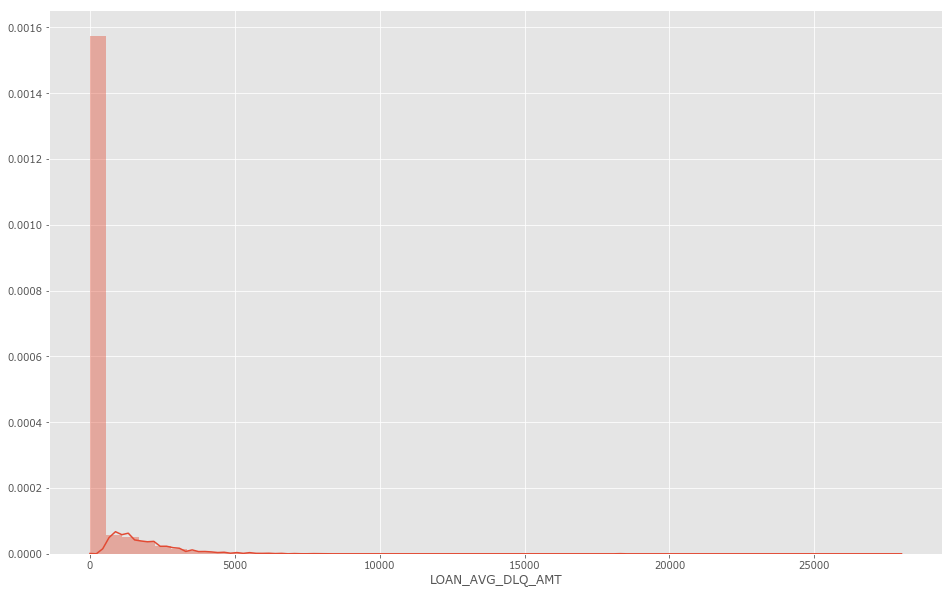

In [59]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[15]])

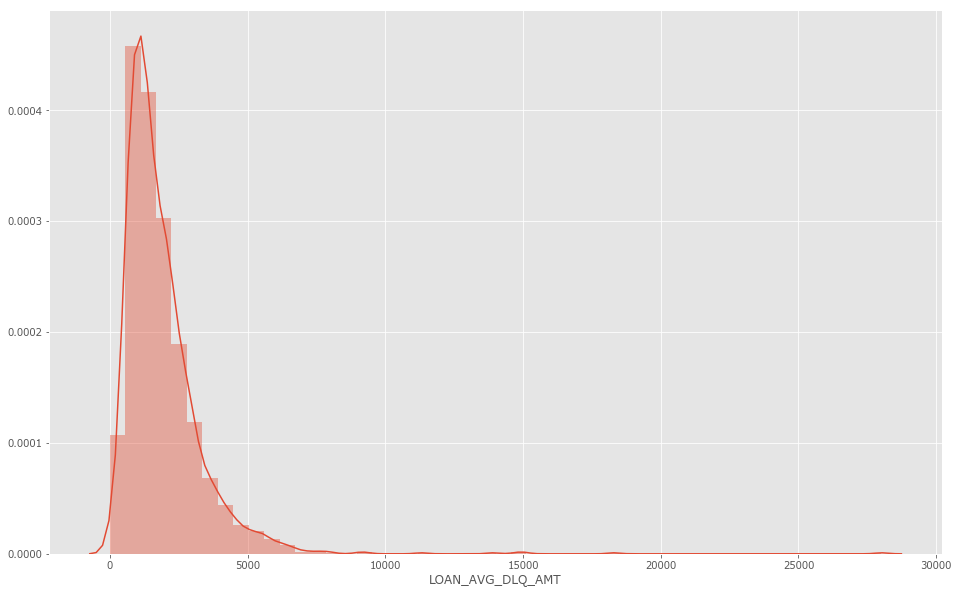

In [60]:
# без нуля
plt.subplots(figsize=(16, 10))

sns.distplot(data[data['LOAN_AVG_DLQ_AMT'] != 0]['LOAN_AVG_DLQ_AMT'])

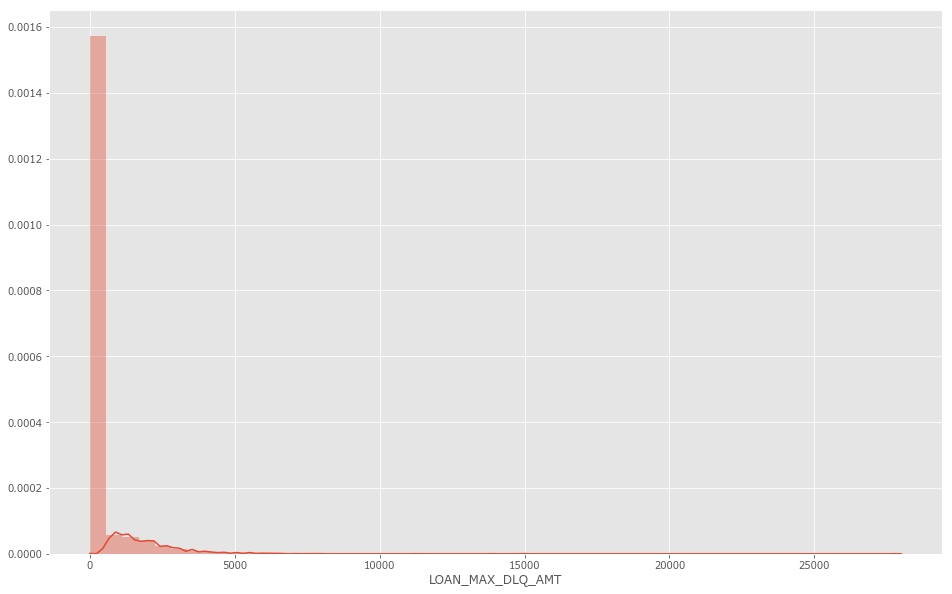

In [61]:
plt.subplots(figsize=(16, 10))

sns.distplot(data[num_columns[16]])

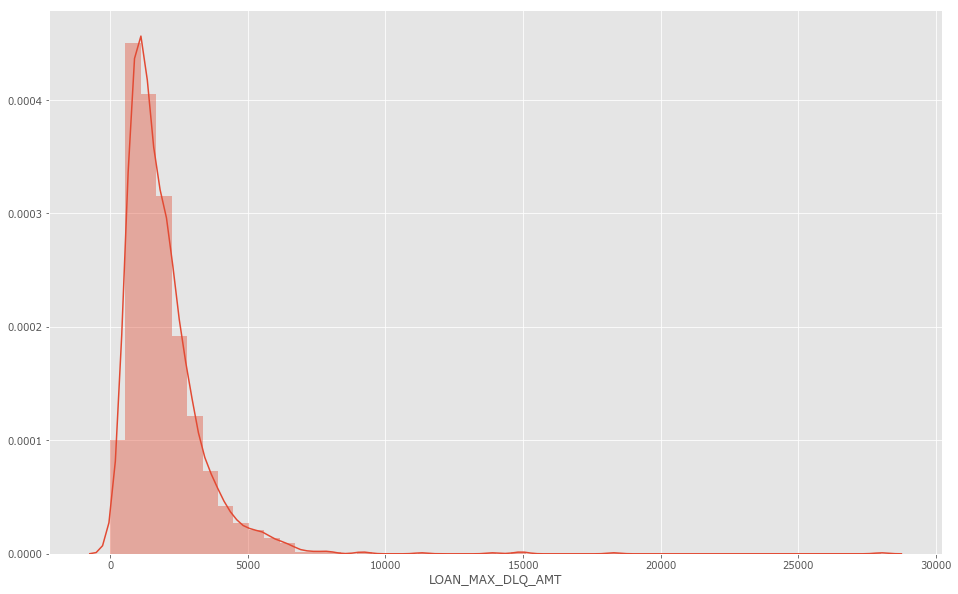

In [62]:
# без нуля
plt.subplots(figsize=(16, 10))

sns.distplot(data[data['LOAN_MAX_DLQ_AMT'] != 0]['LOAN_MAX_DLQ_AMT'])

## Бининг

In [63]:
cat_columns, num_columns = columns()

In [64]:
cols_enl = show_binning(categorical_columns=cat_columns)

Среднее специальное               6518
Среднее                           4679
Высшее                            3133
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образования      20
Ученая степень                       1
Name: EDUCATION, dtype: int64

Торговля                                     2385
Другие сферы                                 1709
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   

In [65]:
data[cols_enl[0]].value_counts()

Среднее специальное               6518
Среднее                           4679
Высшее                            3133
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образования      20
Ученая степень                       1
Name: EDUCATION, dtype: int64

In [66]:
data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'

In [67]:
data[cols_enl[1]].value_counts()

Торговля                                     2385
Другие сферы                                 1709
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [68]:
data.at[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
small_categories_aggregation(column='GEN_INDUSTRY', n_samples=20, value='Другие сферы')
data[cols_enl[1]].value_counts()

Торговля                                     2385
Другие сферы                                 1756
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [69]:
data[cols_enl[2]].value_counts()

Специалист                        7010
Рабочий                           3075
nan                               1367
Служащий                           904
Руководитель среднего звена        697
Работник сферы услуг               563
Высококвалифиц. специалист         549
Руководитель высшего звена         427
Индивидуальный предприниматель     217
Другое                             177
Руководитель низшего звена         136
Военнослужащий по контракту         88
Партнер                             13
Name: GEN_TITLE, dtype: int64

In [70]:
data[cols_enl[3]].value_counts()

Частная компания                  6523
Государственная комп./учреж.      6112
nan                               1367
Индивидуальный предприниматель     957
Некоммерческая организация         243
Частная ком. с инос. капиталом      21
Name: ORG_TP_STATE, dtype: int64

In [71]:
data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'

In [72]:
data[cols_enl[4]].value_counts()

Участие в основ. деятельности    11452
nan                               1367
Вспомогательный техперсонал       1025
Бухгалтерия, финансы, планир.      481
Адм-хоз. и трансп. службы          279
Снабжение и сбыт                   217
Служба безопасности                164
Кадровая служба и секретариат      101
Пр-техн. обесп. и телеком.          75
Юридическая служба                  53
Реклама и маркетинг                  9
Name: JOB_DIR, dtype: int64

In [73]:
data.at[data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Юридическая служба'

In [74]:
data[cols_enl[5]].value_counts()

от 10000 до 20000 руб.    7077
от 20000 до 50000 руб.    6082
от 5000 до 10000 руб.     1512
свыше 50000 руб.           492
до 5000 руб.                60
Name: FAMILY_INCOME, dtype: int64

In [75]:
data[cols_enl[6]].value_counts()

Краснодарский край             674
Кемеровская область            674
Алтайский край                 459
Читинская область              426
Приморский край                416
Ростовская область             407
Свердловская область           349
Волгоградская область          331
Саратовская область            331
Воронежская область            301
Челябинская область            292
Вологодская область            292
Омская область                 287
Татарстан                      287
Кировская область              264
Архангельская область          257
Оренбургская область           253
Тульская область               252
Хабаровский край               252
Красноярский край              239
Самарская область              235
Башкирия                       222
Курская область                217
Белгородская область           215
Новосибирская область          214
Липецкая область               206
Иркутская область              202
Тюменская область              199
Бурятия             

In [76]:
data.at[data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'

In [77]:
data[cols_enl[7]].value_counts()

Кемеровская область            674
Краснодарский край             674
Алтайский край                 454
Читинская область              426
Приморский край                415
Ростовская область             404
Свердловская область           348
Волгоградская область          332
Саратовская область            324
Воронежская область            301
Вологодская область            292
Челябинская область            292
Татарстан                      286
Омская область                 286
Кировская область              266
Архангельская область          255
Хабаровский край               254
Оренбургская область           250
Тульская область               249
Самарская область              239
Красноярский край              237
Башкирия                       221
Новосибирская область          216
Белгородская область           214
Курская область                213
Московская область             207
Иркутская область              203
Липецкая область               202
Тюменская область   

In [78]:
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'

In [79]:
data[cols_enl[8]].value_counts()

Краснодарский край             674
Кемеровская область            674
Алтайский край                 456
Читинская область              426
Приморский край                415
Ростовская область             404
Свердловская область           348
Волгоградская область          331
Саратовская область            326
Воронежская область            302
Вологодская область            293
Челябинская область            292
Татарстан                      287
Омская область                 286
Кировская область              266
Архангельская область          255
Хабаровский край               254
Оренбургская область           251
Тульская область               249
Самарская область              239
Красноярский край              239
Башкирия                       221
Новосибирская область          215
Курская область                214
Белгородская область           212
Липецкая область               204
Московская область             203
Иркутская область              202
Тюменская область   

In [80]:
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'

In [81]:
data[cols_enl[9]].value_counts()

Краснодарский край         790
Кемеровская область        668
Алтайский край             436
Приморский край            413
Читинская область          412
Ставропольский край        411
Ростовская область         405
Челябинская область        354
Свердловская область       340
Волгоградская область      339
Кировская область          333
Саратовская область        317
Воронежская область        312
nan                        295
Красноярский край          295
Вологодская область        292
Омская область             286
Татарстан                  272
Хабаровский край           258
Санкт-Петербург            254
Оренбургская область       251
Тульская область           245
Архангельская область      243
Новосибирская область      238
Самарская область          236
Амурская область           224
Курская область            212
Белгородская область       211
Бурятия                    211
Ярославская область        208
                          ... 
Пермская область           162
Чувашия 

In [82]:
# потому что соседи
data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'

In [83]:
data[cols_enl[10]].value_counts()

ЮЖНЫЙ                 2179
ЦЕНТРАЛЬНЫЙ 2         1934
ЗАПАДНО-СИБИРСКИЙ     1835
ЦЕНТРАЛЬНЫЙ 1         1653
ПОВОЛЖСКИЙ            1436
ПРИВОЛЖСКИЙ           1270
ВОСТОЧНО-СИБИРСКИЙ    1256
УРАЛЬСКИЙ             1195
ДАЛЬНЕВОСТОЧНЫЙ       1141
СЕВЕРО-ЗАПАДНЫЙ       1028
ЦЕНТРАЛЬНЫЙ ОФИС       295
nan                      1
Name: REGION_NM, dtype: int64

In [84]:
data.at[data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'

In [85]:
data[cols_enl[11]].value_counts()

0    15074
1      149
Name: COT_PRESENCE_FL, dtype: int64

## Добавление фичей

In [86]:
data['SOLVENCY'] = (data['CREDIT']/data['TERM'])/data['PERSONAL_INCOME']

In [87]:
# просрачивал ли клиент когда-либо оплату кредита
data['DELAY'] = '0'
data.at[data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
data.at[data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
data['DELAY'].value_counts()

0    13301
1     1922
Name: DELAY, dtype: int64

In [88]:
cat_columns, num_columns = columns()

In [89]:
for i in cat_columns:
    if len(data[i].value_counts()) > 15:
        print(data[i].value_counts())
        print()

Торговля                                     2385
Другие сферы                                 1756
nan                                          1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 574
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [90]:
data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())
data['POSTAL_ADDRESS_PROVINCE'] = data['POSTAL_ADDRESS_PROVINCE'].map(data['POSTAL_ADDRESS_PROVINCE'].value_counts())
data['TP_PROVINCE'] = data['TP_PROVINCE'].map(data['TP_PROVINCE'].value_counts())

## Обработка численных полей

In [91]:
columns_to_category = ['CHILD_TOTAL', 'DEPENDANTS', 'OWN_AUTO', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED', 'LOAN_DLQ_NUM']

In [92]:
data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)

In [93]:
# переводим в категориальные значения
for i in columns_to_category:
    if i in data.columns:
        data[i]=data[i].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 51 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null object
DEPENDANTS                    15223 non-null object
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null int64
FACT_ADD

In [94]:
for col in columns_to_category:
    print(data[col].value_counts())
    print()

1     5087
0     4984
2     4140
3      799
4      133
5       59
6       12
7        5
10       3
8        1
Name: CHILD_TOTAL, dtype: int64

0    8226
1    4535
2    2167
3     243
4      42
5       5
6       4
7       1
Name: DEPENDANTS, dtype: int64

0    13453
1     1769
2        1
Name: OWN_AUTO, dtype: int64

1     11288
2      2633
3       871
4       275
5       102
6        36
7        14
8         3
11        1
Name: LOAN_NUM_TOTAL, dtype: int64

0     7791
1     4761
2     1770
3      603
4      202
5       62
6       26
7        5
8        2
11       1
Name: LOAN_NUM_CLOSED, dtype: int64

0     13301
1      1416
2       280
3        96
4        48
5        39
6        16
7        14
9         4
8         3
13        2
10        2
11        1
12        1
Name: LOAN_DLQ_NUM, dtype: int64



In [95]:
data.at[data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
data.at[data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'

In [96]:
data.at[data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
data.at[data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
data.at[data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'

In [97]:
data.at[data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'

In [98]:
data.at[data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
data.at[data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'

In [99]:
data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'

In [100]:
data.at[data['LOAN_DLQ_NUM'] == '9', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '8', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '10', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '13', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '11', 'LOAN_DLQ_NUM'] = '7'
data.at[data['LOAN_DLQ_NUM'] == '12', 'LOAN_DLQ_NUM'] = '7'

In [101]:
cats, nums = columns()

In [102]:
data.describe()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,SOLVENCY
count,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000,15223.0000
mean,40.4061,13853.8363,270.7468,269.9668,270.2251,295.1775,14667.9593,8.1010,3398.5627,131.0020,75.5412,7.8760,239.4571,243.0216,0.0191,0.1683
std,11.6011,9015.4676,157.6221,157.3229,157.3993,172.4570,12147.8735,4.0941,5158.1089,107.6183,89.5994,7.9557,827.7004,836.1001,0.1377,1.1911
min,21.0000,24.0000,22.0000,22.0000,22.0000,19.0000,2000.0000,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0058
25%,30.0000,8000.0000,167.0000,165.0000,166.0000,164.0000,6500.0000,6.0000,1000.0000,41.0000,14.0000,4.0000,0.0000,0.0000,0.0000,0.0846
50%,39.0000,12000.0000,217.0000,216.0000,215.0000,251.0000,11550.0000,6.0000,2000.0000,107.0000,40.0000,5.0000,0.0000,0.0000,0.0000,0.1325
75%,50.0000,17000.0000,331.0000,324.0000,326.0000,354.0000,19170.0000,10.0000,4000.0000,204.0000,96.0000,8.0000,0.0000,0.0000,0.0000,0.2027
max,67.0000,250000.0000,674.0000,674.0000,674.0000,790.0000,119700.0000,36.0000,140000.0000,696.0000,516.0000,114.0000,28012.2000,28012.2000,2.0000,146.5417


In [103]:
data[cats].describe()

,TARGET,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,GPF_DOCUMENT_FL,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,DELAY
count,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223
unique,2,2,2,2,5,5,5,5,27,13,5,3,10,5,11,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,7,8,8,2
top,0,1,0,1,1,0,Среднее специальное,Состою в браке,Торговля,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,ЮЖНЫЙ,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0
freq,13411,13847,13176,9964,5087,8226,6518,9416,2385,7010,6544,13688,11452,7077,2180,12765,14480,13493,12758,13782,10507,13453,14097,11940,15074,14930,14558,8961,9311,14389,13855,11288,7791,13301,13301


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 51 columns):
TARGET                        15223 non-null object
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null object
DEPENDANTS                    15223 non-null object
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRESS_PROVINCE          15223 non-null int64
FACT_ADD

In [105]:
dummy_data = pd.get_dummies(data)

# Data Processing Tool
[Вернуться к быстрому перемещению](#Быстрое-перемещение)

## Первая версия

In [106]:
def process_data(data):

    # указано в условии
    data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)
    
    # удаляем id
    data.drop('AGREEMENT_RK', axis=1, inplace=True)
    
    # одно уникальное значение
    data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)
    
    categorical_columns = ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 'EDUCATION', 'MARITAL_STATUS',
                           'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR',
                           'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE',
                           'REGION_NM', 'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
                           'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
                           'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
                           'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL', 
                           'PREVIOUS_CARD_NUM_UTILIZED']
    
    for i in categorical_columns:
        if i in data.columns:
            data[i] = data[i].astype('str')
    
    # если человек нигде не работает, то WORK_TIME = 0
    data.at[(data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0
    
    # максимальное значение, после которого значения считаются "неправильными"
    maxy_work_time = max(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN
    
    true_median = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
    data['WORK_TIME'].fillna(true_median, inplace=True)
    
    data.at[data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    
    maxy_live_term = max(data['FACT_LIVING_TERM'].sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN
    
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
    
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[
                            :heu_const_work_time].median()
    data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)
    
    for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
        if i in data.columns:
            data[i] = data[i].str.replace(',', '.').astype('float')
    
    cat_columns, num_columns = columns()
    
    data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'
    
    data.at[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
    small_categories_aggregation(column='GEN_INDUSTRY', n_samples=20, value='Другие сферы')
    
    data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'
    
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[
        data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    # потому что соседи
    data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'
    
    data.at[data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'
    
    # просрачивал ли клиент когда-либо оплату кредита
    data['DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
    
    cat_columns, num_columns = columns()
    
    data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
    data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())
    data['POSTAL_ADDRESS_PROVINCE'] = data['POSTAL_ADDRESS_PROVINCE'].map(data['POSTAL_ADDRESS_PROVINCE'].value_counts())
    data['TP_PROVINCE'] = data['TP_PROVINCE'].map(data['TP_PROVINCE'].value_counts())
    
    columns_to_category = ['CHILD_TOTAL', 'DEPENDANTS', 'OWN_AUTO', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED', 'LOAN_DLQ_NUM']
    
    data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)
    
    # переводим в категориальные значения
    for i in columns_to_category:
        if i in data.columns:
            data[i] = data[i].astype('str')
    
    data.at[data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'
    
    data.at[data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'
    
    data.at[data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'
    
    data.at[data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
    data.at[data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'
    
    data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    
    data.at[data['LOAN_NUM_CLOSED'] == '9', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '10', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '13', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    
    cats, nums = columns()
    
    return pd.get_dummies(data), data, cats, nums

## Вторая версия

In [107]:
def process_data():
    
    pre_data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep=';')

    pre_data = pre_data.reindex(np.random.permutation(pre_data.index))
    
    data = pre_data[:int(len(pre_data)*0.7)]
    test_data = pre_data[int(len(pre_data)*0.7):]

#     data = pd.read_csv("data/Credit_OTP.csv", encoding='cp1251', sep=';')
#     test_data = pd.read_csv("data/Credit_OTP_new.csv", encoding='cp1251', sep=';')
    
    categorical_columns = ['TARGET', 'SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER', 'EDUCATION', 'MARITAL_STATUS',
                           'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE', 'ORG_TP_FCAPITAL', 'JOB_DIR',
                           'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE',
                           'REGION_NM', 'REG_FACT_FL', 'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
                           'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'AUTO_RUS_FL', 'HS_PRESENCE_FL',
                           'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL', 'DL_DOCUMENT_FL',
                           'GPF_DOCUMENT_FL', 'FACT_PHONE_FL', 'REG_PHONE_FL', 'GEN_PHONE_FL', 
                           'PREVIOUS_CARD_NUM_UTILIZED']        

    # указано в условии
    data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)
    test_data['PREVIOUS_CARD_NUM_UTILIZED'].fillna(0, inplace=True)
    
    # удаляем id
    data.drop('AGREEMENT_RK', axis=1, inplace=True)
    test_data.drop('AGREEMENT_RK', axis=1, inplace=True)
    
    # одно уникальное значение
    data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)
    test_data.drop('DL_DOCUMENT_FL', axis=1, inplace=True)

    
    for i in categorical_columns:
        if i in data.columns:
            data[i] = data[i].astype('str')
            test_data[i] = test_data[i].astype('str')
    
    
    # если человек нигде не работает, то WORK_TIME = 0
    data.at[(data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0
    test_data.at[(test_data['GEN_INDUSTRY'] == 'nan') & (data['GEN_TITLE'] == 'nan'), 'WORK_TIME'] = 0
    
    # эспериментально выбранное значение
    heu_const_work_time = 15200
    true_median = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
    
    # максимальное значение, после которого значения считаются "неправильными"
    maxy_work_time = max(data['WORK_TIME'].dropna().sort_values()[:heu_const_work_time])
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN
    
    try:
        test_data.at[data['WORK_TIME'] > maxy_work_time, 'WORK_TIME'] = np.NaN
    except:
        pass
    
    true_median_work_time = data[data['WORK_TIME'] != 0]['WORK_TIME'].dropna().sort_values()[:heu_const_work_time].median()
    data['WORK_TIME'].fillna(true_median_work_time, inplace=True)
    test_data['WORK_TIME'].fillna(true_median_work_time, inplace=True)
    
    data.at[data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    test_data.at[test_data['FACT_LIVING_TERM'] < 0, 'FACT_LIVING_TERM'] = 0
    
    maxy_live_term = 696
    
    # считаем значения больше maxy_work_time - пропущенными
    data.at[data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN
    test_data.at[test_data['FACT_LIVING_TERM'] > maxy_live_term, 'FACT_LIVING_TERM'] = np.NaN
    
    true_median_live_term = data[data['FACT_LIVING_TERM'] != 0]['FACT_LIVING_TERM'].dropna().sort_values()[:heu_const_work_time].median()
    data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)
    test_data['FACT_LIVING_TERM'].fillna(true_median, inplace=True)
    
    for i in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
        if i in data.columns:
            data[i] = data[i].str.replace(',', '.').astype('float')
            test_data[i] = test_data[i].str.replace(',', '.').astype('float')
    
    cat_columns, num_columns = columns()
    
    data.at[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    data.at[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'
    test_data.at[test_data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    test_data.at[test_data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'
    
    
    data.at[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
    test_data.at[test_data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'СМИ/Реклама/PR-агенства'
    
    tmp_small_columns = data['GEN_INDUSTRY'].value_counts()[data['GEN_INDUSTRY'].value_counts() < 20].index

    for col in tmp_small_columns:
        data.at[data['GEN_INDUSTRY'] == col, 'GEN_INDUSTRY'] = 'Другие сферы'
        test_data.at[test_data['GEN_INDUSTRY'] == col, 'GEN_INDUSTRY'] = 'Другие сферы'
    
    
    data.at[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'
    test_data.at[test_data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 'ORG_TP_STATE'] = 'Частная компания'
    
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'REG_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['REG_ADDRESS_PROVINCE'] == 'Дагестан', 'REG_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'FACT_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['FACT_ADDRESS_PROVINCE'] == 'Дагестан', 'FACT_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Эвенкийский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Агинский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Усть-Ордынский Бурятский АО', 'POSTAL_ADDRESS_PROVINCE'] = 'Красноярский край'
    test_data.at[test_data['POSTAL_ADDRESS_PROVINCE'] == 'Дагестан', 'POSTAL_ADDRESS_PROVINCE'] = 'Северная Осетия'
    
    # потому что соседи
    data.at[data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'
    test_data.at[test_data['TP_PROVINCE'] == 'Кабардино-Балкария', 'TP_PROVINCE'] = 'Ставропольский край'
    
    data.at[data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'
    test_data.at[test_data['REGION_NM'] == 'nan', 'REGION_NM'] = 'ЮЖНЫЙ'
    
    # просрачивал ли клиент когда-либо оплату кредита
    data['DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
    data.at[data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
    test_data['DELAY'] = '0'
    test_data.at[test_data['LOAN_DLQ_NUM'] == 0, 'DELAY'] = '0'
    test_data.at[test_data['LOAN_DLQ_NUM'] > 0, 'DELAY'] = '1'
    
    cat_columns, num_columns = columns()
    
    tmp_data = data.copy()
    
    data['REG_ADDRESS_PROVINCE'] = data['REG_ADDRESS_PROVINCE'].map(data['REG_ADDRESS_PROVINCE'].value_counts())
    data['FACT_ADDRESS_PROVINCE'] = data['FACT_ADDRESS_PROVINCE'].map(data['FACT_ADDRESS_PROVINCE'].value_counts())
    data['POSTAL_ADDRESS_PROVINCE'] = data['POSTAL_ADDRESS_PROVINCE'].map(data['POSTAL_ADDRESS_PROVINCE'].value_counts())
    data['TP_PROVINCE'] = data['TP_PROVINCE'].map(data['TP_PROVINCE'].value_counts())
    
    test_data_freq_func_reg = lambda x: DataFrame(tmp_data['REG_ADDRESS_PROVINCE'].value_counts()).loc[x, 'REG_ADDRESS_PROVINCE']
    test_data_freq_func_fact = lambda x: DataFrame(tmp_data['FACT_ADDRESS_PROVINCE'].value_counts()).loc[x, 'FACT_ADDRESS_PROVINCE']
    test_data_freq_func_postal = lambda x: DataFrame(tmp_data['POSTAL_ADDRESS_PROVINCE'].value_counts()).loc[x, 'POSTAL_ADDRESS_PROVINCE']
    test_data_freq_func_tp = lambda x: DataFrame(tmp_data['TP_PROVINCE'].value_counts()).loc[x, 'TP_PROVINCE']

    test_data['REG_ADDRESS_PROVINCE'] = test_data['REG_ADDRESS_PROVINCE'].map(test_data_freq_func_reg)
    test_data['FACT_ADDRESS_PROVINCE'] = test_data['FACT_ADDRESS_PROVINCE'].map(test_data_freq_func_fact)
    test_data['POSTAL_ADDRESS_PROVINCE'] = test_data['POSTAL_ADDRESS_PROVINCE'].map(test_data_freq_func_postal)
    test_data['TP_PROVINCE'] = test_data['TP_PROVINCE'].map(test_data_freq_func_tp)
    
    data.at[data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Юридическая служба'
    test_data.at[test_data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Юридическая служба'
    
    columns_to_category = ['CHILD_TOTAL', 'DEPENDANTS', 'OWN_AUTO', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED',
                           'LOAN_DLQ_NUM']
    
    data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)
    test_data.drop('LOAN_MAX_DLQ', axis=1, inplace=True)
    
    # переводим в категориальные значения
    for i in columns_to_category:
        if i in data.columns:
            data[i] = data[i].astype('str')
            test_data[i] = test_data[i].astype('str')  
    
    data.at[data['PREVIOUS_CARD_NUM_UTILIZED'] == '2.0', 'PREVIOUS_CARD_NUM_UTILIZED'] = '1.0'
    test_data.at[test_data['PREVIOUS_CARD_NUM_UTILIZED'] == '2.0', 'PREVIOUS_CARD_NUM_UTILIZED'] = '1.0'
    
    data.at[data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
    data.at[data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '5', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '6', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '7', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '10', 'CHILD_TOTAL'] = '4'
    test_data.at[test_data['CHILD_TOTAL'] == '8', 'CHILD_TOTAL'] = '4'
    
    data.at[data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
    data.at[data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'    
    test_data.at[test_data['DEPENDANTS'] == '5', 'DEPENDANTS'] = '4'
    test_data.at[test_data['DEPENDANTS'] == '6', 'DEPENDANTS'] = '4'
    test_data.at[test_data['DEPENDANTS'] == '7', 'DEPENDANTS'] = '4'
    
    data.at[data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'
    test_data.at[test_data['OWN_AUTO'] == '2', 'OWN_AUTO'] = '1'
    
    data.at[data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
    data.at[data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'
    test_data.at[test_data['LOAN_NUM_TOTAL'] == '8', 'LOAN_NUM_TOTAL'] = '7'
    test_data.at[test_data['LOAN_NUM_TOTAL'] == '11', 'LOAN_NUM_TOTAL'] = '7'
    
#     data.at[data['LOAN_NUM_CLOSED'] == '7', 'LOAN_NUM_CLOSED'] = '6'
    data.at[data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    data.at[data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
#     test_data.at[test_data['LOAN_NUM_CLOSED'] == '7', 'LOAN_NUM_CLOSED'] = '6'
    test_data.at[test_data['LOAN_NUM_CLOSED'] == '8', 'LOAN_NUM_CLOSED'] = '7'
    test_data.at[test_data['LOAN_NUM_CLOSED'] == '11', 'LOAN_NUM_CLOSED'] = '7'
    
#     data.drop('LOAN_NUM_CLOSED', axis=1, inplace=True)
#     test_data.drop('LOAN_NUM_CLOSED', axis=1, inplace=True)
    
    data.at[data['LOAN_DLQ_NUM'] == '9', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '8', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '10', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '13', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '11', 'LOAN_DLQ_NUM'] = '7'
    data.at[data['LOAN_DLQ_NUM'] == '12', 'LOAN_DLQ_NUM'] = '7'
    
    test_data.at[test_data['LOAN_DLQ_NUM'] == '9', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '8', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '10', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '13', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '11', 'LOAN_DLQ_NUM'] = '7'
    test_data.at[test_data['LOAN_DLQ_NUM'] == '12', 'LOAN_DLQ_NUM'] = '7'
    
#     aggr_cols = ['AUTO_RUS_FL', 'HS_PRESENCE_FL', 'COT_PRESENCE_FL', 'GAR_PRESENCE_FL', 'LAND_PRESENCE_FL']
    
#     for i in aggr_cols:
        
#         data['AGGR_COLS'] = 0
#         test_data['AGGR_COLS'] = 0
        
#         data['AGGR_COLS'] += data[i].astype('int32')
#         test_data['AGGR_COLS'] += test_data[i].astype('int32')
        
#         data.drop(i, axis=1, inplace=True)
#         test_data.drop(i, axis=1, inplace=True)
    
    data['SOLVENCY'] = (data['CREDIT']/data['TERM'])/data['PERSONAL_INCOME']
    test_data['SOLVENCY'] = (test_data['CREDIT']/test_data['TERM'])/test_data['PERSONAL_INCOME']
    
    data.at[data['SOLVENCY'] > 100, 'SOLVENCY'] = data[data['SOLVENCY'] < 100]['SOLVENCY'].median()
    test_data.at[test_data['SOLVENCY'] > 100, 'SOLVENCY'] = test_data[test_data['SOLVENCY'] < 100]['SOLVENCY'].median()

    
#     data['PERCENT_FIRST_PAYMENT'] = data['FST_PAYMENT']/data['PERSONAL_INCOME']
#     test_data['PERCENT_FIRST_PAYMENT'] = test_data['FST_PAYMENT']/test_data['PERSONAL_INCOME']
    
    cats, nums = columns(data)
    
    data.reset_index(inplace=True)
    test_data.reset_index(inplace=True)
    
    data.drop('index', axis=1, inplace=True)
    test_data.drop('index', axis=1, inplace=True)
    
    dummy_train = pd.get_dummies(data)
    dummy_test = pd.get_dummies(test_data)
    
    return dummy_train, data, dummy_test, test_data, cats, nums

In [108]:
train_dummy, train_data, test_dummy, test_data, cats, nums = process_data()

In [109]:
cats

['TARGET',
 'SOCSTATUS_WORK_FL',
 'SOCSTATUS_PENS_FL',
 'GENDER',
 'CHILD_TOTAL',
 'DEPENDANTS',
 'EDUCATION',
 'MARITAL_STATUS',
 'GEN_INDUSTRY',
 'GEN_TITLE',
 'ORG_TP_STATE',
 'ORG_TP_FCAPITAL',
 'JOB_DIR',
 'FAMILY_INCOME',
 'REGION_NM',
 'REG_FACT_FL',
 'FACT_POST_FL',
 'REG_POST_FL',
 'REG_FACT_POST_FL',
 'REG_FACT_POST_TP_FL',
 'FL_PRESENCE_FL',
 'OWN_AUTO',
 'AUTO_RUS_FL',
 'HS_PRESENCE_FL',
 'COT_PRESENCE_FL',
 'GAR_PRESENCE_FL',
 'LAND_PRESENCE_FL',
 'GPF_DOCUMENT_FL',
 'FACT_PHONE_FL',
 'REG_PHONE_FL',
 'GEN_PHONE_FL',
 'LOAN_NUM_TOTAL',
 'LOAN_NUM_CLOSED',
 'LOAN_DLQ_NUM',
 'PREVIOUS_CARD_NUM_UTILIZED',
 'DELAY']

In [110]:
nums

['AGE',
 'PERSONAL_INCOME',
 'REG_ADDRESS_PROVINCE',
 'FACT_ADDRESS_PROVINCE',
 'POSTAL_ADDRESS_PROVINCE',
 'TP_PROVINCE',
 'CREDIT',
 'TERM',
 'FST_PAYMENT',
 'FACT_LIVING_TERM',
 'WORK_TIME',
 'LOAN_NUM_PAYM',
 'LOAN_AVG_DLQ_AMT',
 'LOAN_MAX_DLQ_AMT',
 'SOLVENCY']

In [111]:
train_dummy.head()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,SOLVENCY,TARGET_0,TARGET_1,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,...,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
0,35,12000.0000,290,291,291,289,8857.0000,10,3293.0000,108.0000,24.0000,19,830.0000,830.0000,0.0738,1,0,0,1,1,0,1,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
1,34,35000.0000,128,126,127,104,90000.0000,24,30000.0000,72.0000,144.0000,5,0.0000,0.0000,0.1071,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,33,9000.0000,141,142,142,109,4490.0000,10,1000.0000,139.0000,6.0000,34,560.0000,560.0000,0.0499,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
3,61,20000.0000,474,473,473,549,15740.0000,7,1750.0000,264.0000,144.0000,18,0.0000,0.0000,0.1124,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,26,12000.0000,158,154,156,156,7978.0000,9,0.0000,48.0000,46.0000,4,0.0000,0.0000,0.0739,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [112]:
test_dummy.head()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,SOLVENCY,TARGET_0,TARGET_1,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,...,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
0,33,7000.0000,235,230,231,223,11800.0000,10,3000.0000,104.0000,48.0000,11,0.0000,0.0000,0.1686,1,0,0,1,1,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,52,8000.0000,99,102,102,549,9169.0000,9,1050.0000,8.0000,48.0000,4,0.0000,0.0000,0.1273,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,27,10000.0000,481,480,480,476,3681.0000,3,0.0000,48.0000,7.0000,3,1350.0000,1350.0000,0.1227,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,44,13000.0000,127,127,127,105,5119.0000,6,570.0000,240.0000,180.0000,5,0.0000,0.0000,0.0656,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,29,20000.0000,277,274,274,275,25109.0000,10,2790.0000,36.0000,24.0000,5,0.0000,0.0000,0.1255,1,0,0,1,1,0,1,0,0,1,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [113]:
len(train_data), len(test_data)

(10656, 4567)

In [114]:
train_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Columns: 175 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(160)
memory usage: 2.8 MB


In [115]:
test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4567 entries, 0 to 4566
Columns: 175 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(160)
memory usage: 1.2 MB


In [116]:
for i in test_dummy.columns:
    if i not in list(train_dummy.columns):
        print(i)

In [117]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                train_dummy.loc[:, 'TARGET_1'], test_size=0.3)

In [118]:
Xtrain.head()

,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,SOLVENCY,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,DEPENDANTS_2,DEPENDANTS_3,...,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
7955,50,16000.0000,93,85,85,175,10752.0000,6,2688.0000,174.0000,9.0000,4,0.0000,0.0000,0.1120,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,...,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2296,35,30000.0000,65,63,63,102,35091.0000,6,3899.9500,44.0000,53.0000,5,0.0000,0.0000,0.1950,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
3040,30,8000.0000,180,180,180,231,2390.0000,6,300.0000,300.0000,24.0000,6,0.0000,0.0000,0.0498,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
611,36,30000.0000,175,172,175,210,19990.0000,10,3000.0000,20.0000,30.0000,4,2470.0000,2470.0000,0.0666,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
2688,29,7000.0000,113,109,110,105,13490.0000,18,1500.0000,144.0000,18.0000,5,0.0000,0.0000,0.1071,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [119]:
Xtrain.reset_index(inplace=True)
Xtrain.drop('index', axis=1, inplace=True)

Xtest.reset_index(inplace=True)
Xtest.drop('index', axis=1, inplace=True)

ytrain = ytrain.reset_index()
ytrain.drop('index', axis=1, inplace=True)
ytrain = ytrain['TARGET_1']

ytest = ytest.reset_index()
ytest.drop('index', axis=1, inplace=True)
ytest = ytest['TARGET_1']

## Построение RF без подгонки параметров

In [120]:
forest = RandomForestClassifier(n_estimators=250, max_depth=9, max_features=15, n_jobs=-1, random_state=42)
forest.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict_proba(Xtest)[:, 1])

0.667253561713311

In [121]:
X = test_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1)
y = test_dummy.loc[:, 'TARGET_1']

In [122]:
for i in Xtrain.columns:
    if i not in list(X.columns):
        print(i)

In [123]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7459 entries, 0 to 7458
Columns: 173 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(158)
memory usage: 2.0 MB


In [124]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4567 entries, 0 to 4566
Columns: 173 entries, AGE to DELAY_1
dtypes: float64(8), int64(7), uint8(158)
memory usage: 1.2 MB


In [125]:
# roc_auc_score(y, forest.predict_proba(X)[:, 1])

# Построение моделей
[Вернуться к быстрому перемещению](#Быстрое-перемещение)

## Случайный лес

### Кривые валидации

In [126]:
strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Trained on value: 100, AUC: 0.667
Trained on value: 150, AUC: 0.671
Trained on value: 200, AUC: 0.671
Trained on value: 250, AUC: 0.672
Trained on value: 300, AUC: 0.673
Trained on value: 350, AUC: 0.674
Trained on value: 400, AUC: 0.673
Trained on value: 450, AUC: 0.674
Trained on value: 500, AUC: 0.675
Trained on value: 550, AUC: 0.674


,AUC,Value
Best,0.6745,500


Text(0.5,0,'Количество деревьев')

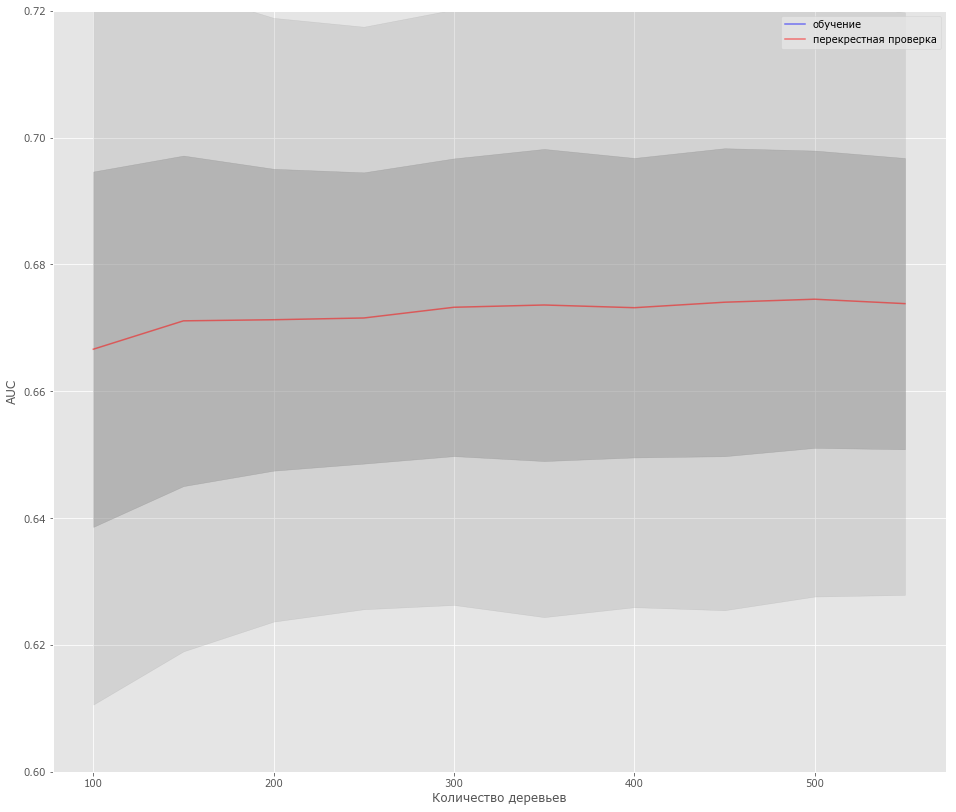

In [127]:
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
trees_grid = list(range(100, 551, 50))

for ntrees in trees_grid:
    rf = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(Xtrain, ytrain):
        X_train, X_test = Xtrain.iloc[train_index], Xtrain.iloc[test_index]
        y_train, y_test = ytrain[train_index], ytrain[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    print('Trained on value: {}, AUC: {:.3f}'.format(ntrees, np.array(temp_test_auc).mean()))

train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
display(DataFrame({'AUC': [max(test_auc.mean(axis=1))],
                   'Value': [trees_grid[np.argmax(test_auc.mean(axis=1))]]}, index=['Best']))

fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(trees_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', 
        label='обучение')
ax.plot(trees_grid, test_auc.mean(axis=1), alpha=0.5, color='red', 
        label='перекрестная проверка')
ax.fill_between(trees_grid, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.6, 0.72])
ax.set_ylabel("AUC")
ax.set_xlabel("Количество деревьев")

In [128]:
len(Xtrain.columns)**(1/2)*1/3, len(Xtrain.columns)**(1/2)*2

(4.384315479321969, 26.30589287593181)

Trained on value: 3, AUC: 0.678
Trained on value: 6, AUC: 0.680
Trained on value: 9, AUC: 0.676
Trained on value: 12, AUC: 0.673
Trained on value: 15, AUC: 0.668
Trained on value: 18, AUC: 0.675
Trained on value: 21, AUC: 0.672
Trained on value: 24, AUC: 0.670
Trained on value: 27, AUC: 0.666
Trained on value: 30, AUC: 0.666
Trained on value: 33, AUC: 0.669


,AUC,Value
Best,0.6803,6


Text(0.5,0,'Количество случайно отбираемых предикторов для разбиения')

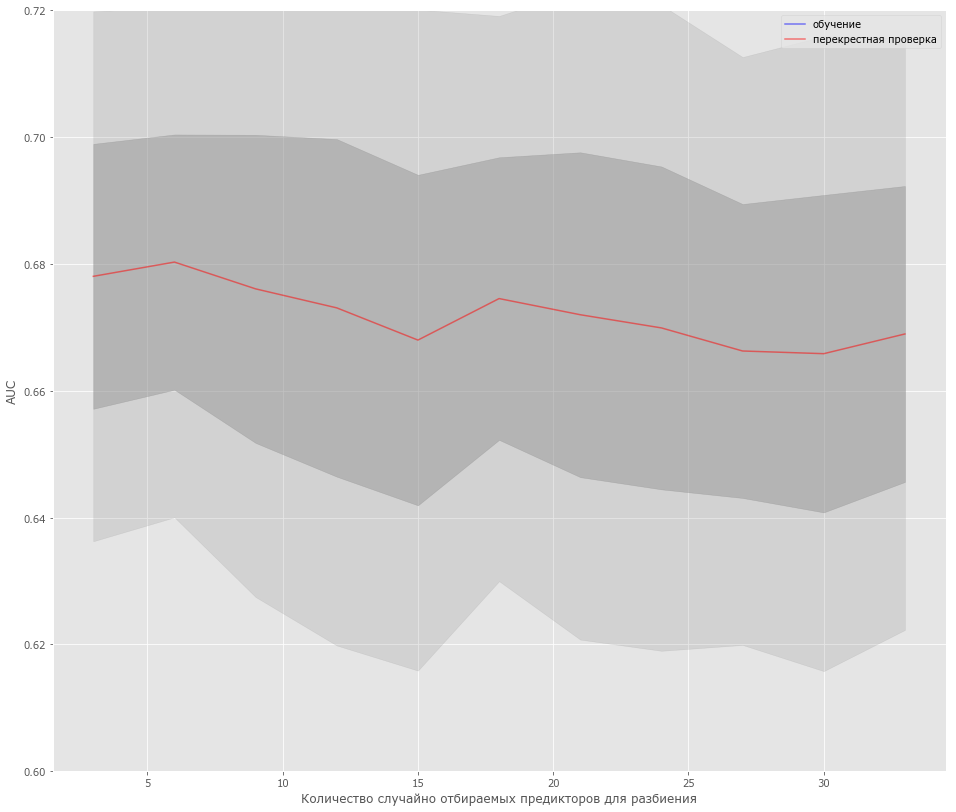

In [129]:
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
max_features_grid = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]

for max_features in max_features_grid:
    rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_features=max_features)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    print('Trained on value: {}, AUC: {:.3f}'.format(max_features, np.array(temp_test_auc).mean()))

train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
display(DataFrame({'AUC': [max(test_auc.mean(axis=1))],
                   'Value': max_features_grid[np.argmax(test_auc.mean(axis=1))]}, index=['Best']))

fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(max_features_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(max_features_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(max_features_grid, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.6, 0.72])
ax.set_ylabel("AUC")
ax.set_xlabel("Количество случайно отбираемых предикторов для разбиения")

Trained on value: 4, AUC: 0.673
Trained on value: 6, AUC: 0.679
Trained on value: 8, AUC: 0.681
Trained on value: 9, AUC: 0.680
Trained on value: 10, AUC: 0.676
Trained on value: 12, AUC: 0.681
Trained on value: 14, AUC: 0.675
Trained on value: 16, AUC: 0.672
Trained on value: 18, AUC: 0.673
Trained on value: 20, AUC: 0.676
Trained on value: 22, AUC: 0.676


,AUC,Value
Best,0.6811,8


Text(0.5,0,'Максимальная глубина')

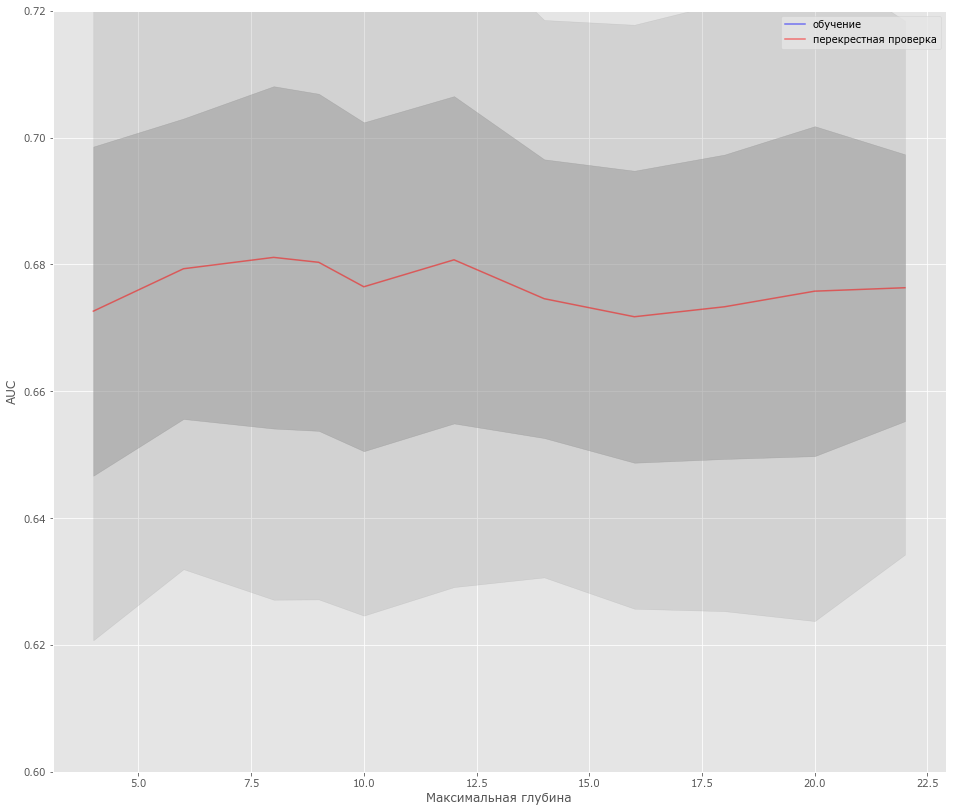

In [130]:
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
max_depth_grid = [4, 6, 8, 9, 10, 12, 14, 16, 18, 20, 22]

for max_depth in max_depth_grid:
    rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1,
                                max_depth=max_depth, max_features=8)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    print('Trained on value: {}, AUC: {:.3f}'.format(max_depth, np.array(temp_test_auc).mean()))

train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
display(DataFrame({'AUC': [max(test_auc.mean(axis=1))],
                   'Value': max_depth_grid[np.argmax(test_auc.mean(axis=1))]}, index=['Best']))

fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(max_depth_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(max_depth_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(max_depth_grid, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.6, 0.72])
ax.set_ylabel("AUC")
ax.set_xlabel("Максимальная глубина")

Trained on value: 1, AUC: 0.680
Trained on value: 3, AUC: 0.681
Trained on value: 5, AUC: 0.682
Trained on value: 7, AUC: 0.684
Trained on value: 9, AUC: 0.683
Trained on value: 11, AUC: 0.682
Trained on value: 13, AUC: 0.681
Trained on value: 15, AUC: 0.681
Trained on value: 17, AUC: 0.681
Trained on value: 20, AUC: 0.681
Trained on value: 22, AUC: 0.680
Trained on value: 24, AUC: 0.678


,AUC,Value
Best,0.6837,7


Text(0.5,0,'Минимальное количество наблюдений в листе')

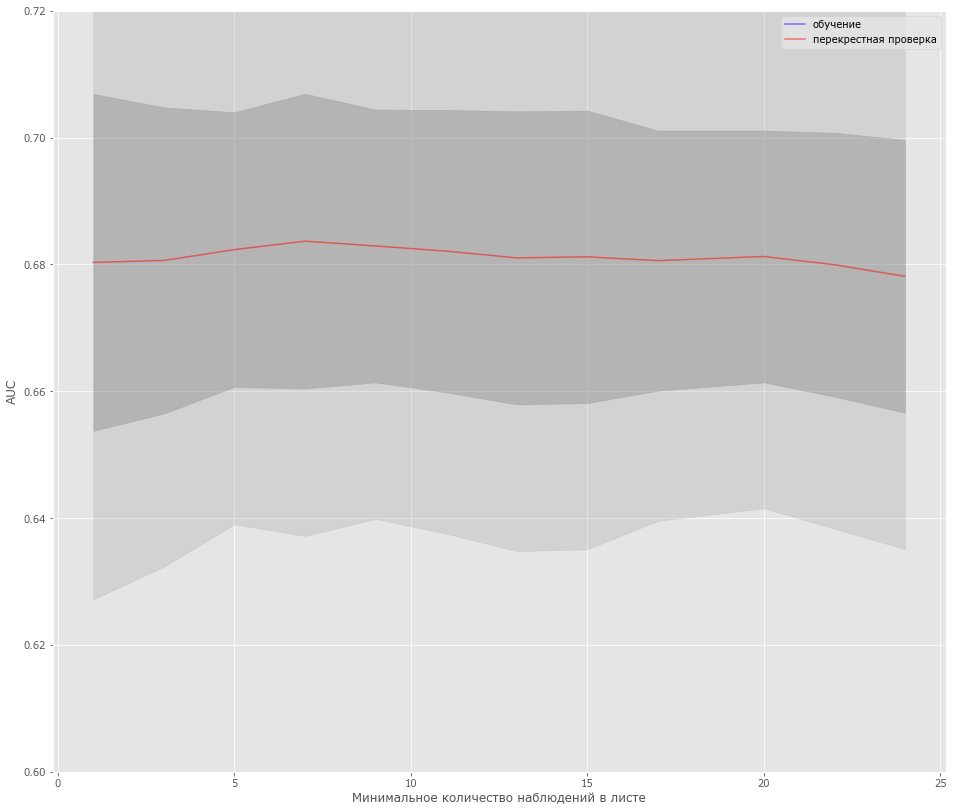

In [131]:
train_auc = []
test_auc = []
temp_train_auc = []
temp_test_auc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for min_samples_leaf in min_samples_leaf_grid:
    rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_features=8, max_depth=9,
                                min_samples_leaf=min_samples_leaf)
    temp_train_auc = []
    temp_test_auc = []
    for train_index, test_index in strat.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1]))
        temp_test_auc.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
    train_auc.append(temp_train_auc)
    test_auc.append(temp_test_auc)
    print('Trained on value: {}, AUC: {:.3f}'.format(min_samples_leaf, np.array(temp_test_auc).mean()))

train_auc, test_auc = np.asarray(train_auc), np.asarray(test_auc)
display(DataFrame({'AUC': [max(test_auc.mean(axis=1))],
                   'Value': min_samples_leaf_grid[np.argmax(test_auc.mean(axis=1))]}, index=['Best']))

fig, ax = plt.subplots(figsize=(16, 14))
ax.plot(min_samples_leaf_grid, train_auc.mean(axis=1), alpha=0.5, color='blue', label='обучение')
ax.plot(min_samples_leaf_grid, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(min_samples_leaf_grid, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.6, 0.72])
ax.set_ylabel("AUC")
ax.set_xlabel("Минимальное количество наблюдений в листе")

In [132]:
forest = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_features=8, max_depth=9,
                                min_samples_leaf=13)
forest.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict_proba(Xtest)[:, 1])

0.6733165429480382

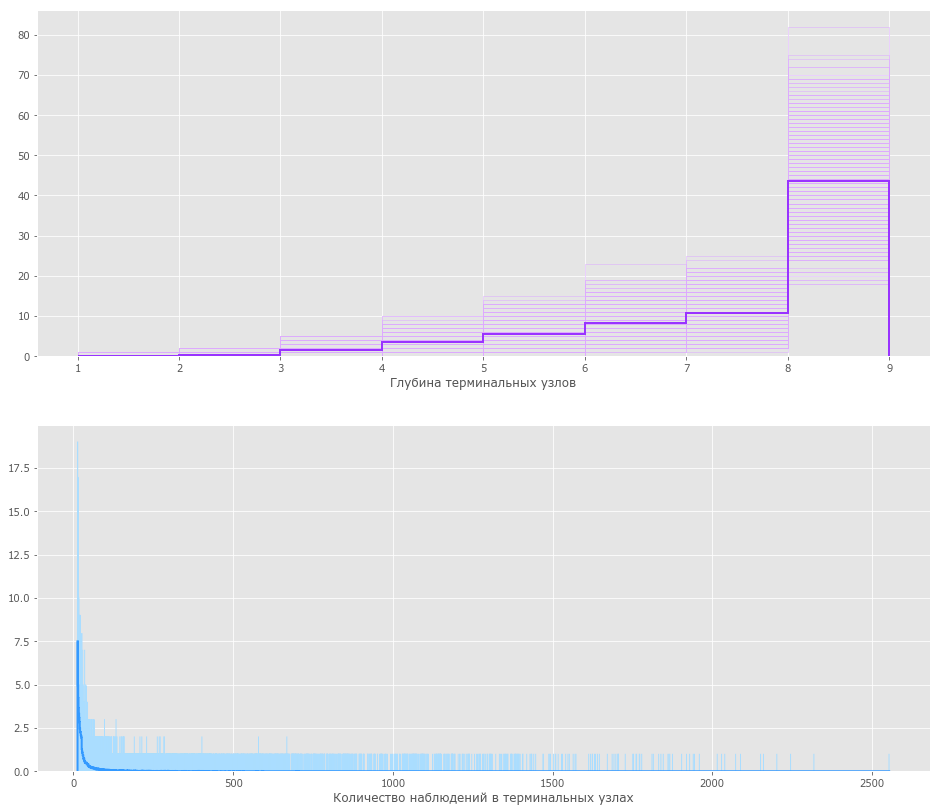

In [133]:
draw_ensemble(forest)

In [134]:
roc_auc_score(y, forest.predict_proba(X)[:, 1])

0.6991603046546464

In [135]:
feat_labels = Xtrain.columns
importances =  forest.feature_importances_
indices = np.argsort(importances)[::-1]
display(DataFrame({'feature': feat_labels[indices], 'importance': importances[indices]}))

,feature,importance
0,SOLVENCY,0.0544
1,AGE,0.0507
2,WORK_TIME,0.0429
3,PERSONAL_INCOME,0.0416
4,FST_PAYMENT,0.0415
5,CREDIT,0.0360
6,FACT_LIVING_TERM,0.0360
7,LOAN_MAX_DLQ_AMT,0.0292
8,LOAN_AVG_DLQ_AMT,0.0292
9,TERM,0.0287


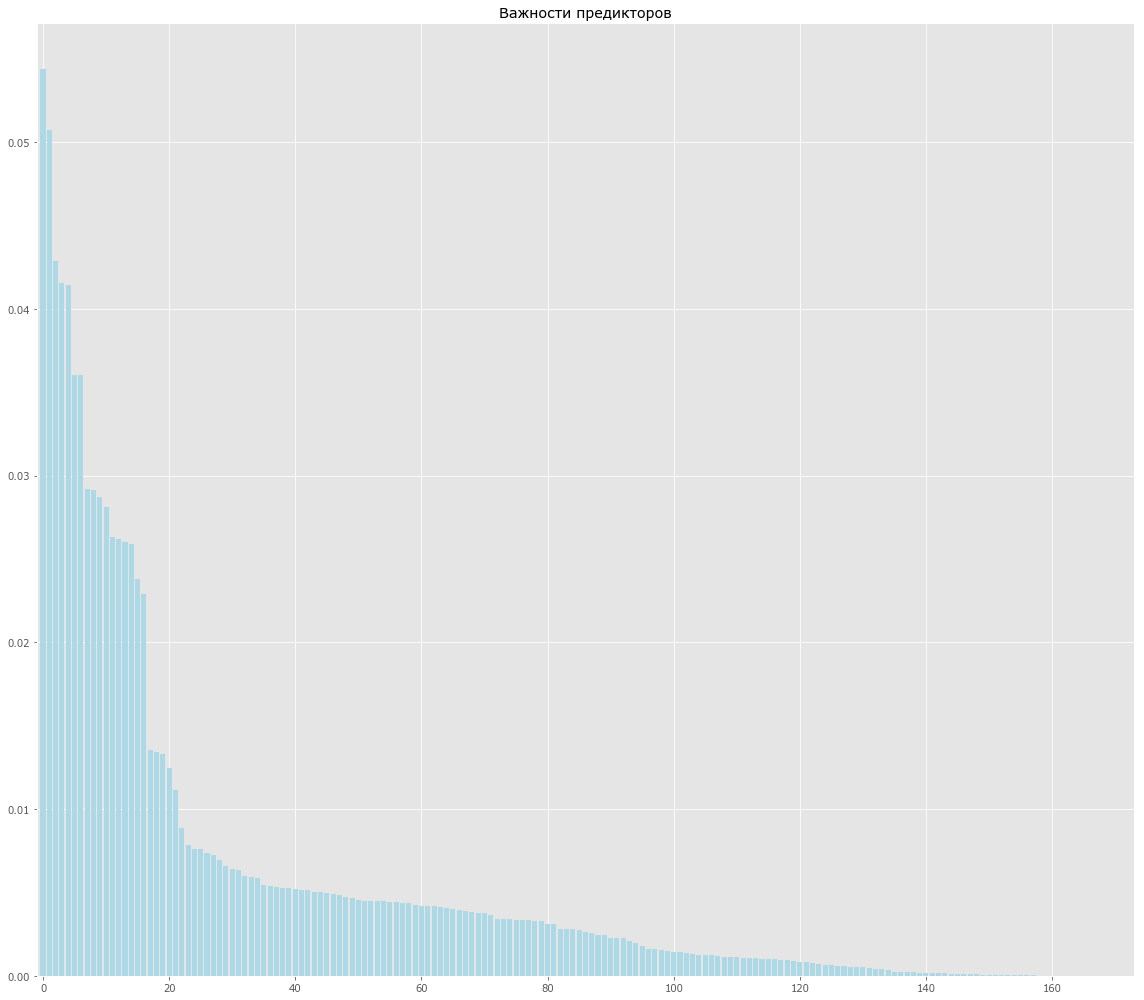

In [136]:
fig, ax = plt.subplots(figsize=(16, 14))

plt.title('Важности предикторов')

plt.bar(range(Xtrain.shape[1]), importances[indices],
              color='lightblue', align='center')

plt.xlim([-1, Xtrain.shape[1]])
plt.tight_layout()
plt.show()

### Grid Search

In [137]:
params = {'max_features': [9, 12, 15, 18, 21, 24, 27, 30, 33], 'max_depth': [3, 4, 5, 7, 9, 12, 15]}

In [138]:
rf = RandomForestClassifier(n_estimators=450, random_state=42)
grid_search = GridSearchCV(rf, params, n_jobs=-1, cv=strat, scoring='roc_auc', verbose=True)

In [139]:
grid_search.fit(Xtrain, ytrain)

Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed: 10.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [9, 12, 15, 18, 21, 24, 27, 30, 33], 'max_depth': [3, 4, 5, 7, 9, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [140]:
grid_search.best_score_

0.6862056040348066

In [141]:
grid_search.best_params_

{'max_depth': 9, 'max_features': 15}

In [142]:
forest = RandomForestClassifier(n_estimators=400, max_depth=9, max_features=9, n_jobs=-1)
forest.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict_proba(Xtest)[:, 1])

0.6675311601887286

In [143]:
roc_auc_score(y, forest.predict_proba(X)[:, 1])

0.6912028263576804

In [144]:
feat_labels = Xtrain.columns
importances =  forest.feature_importances_
indices = np.argsort(importances)[::-1]
display(DataFrame({'feature': feat_labels[indices], 'importance': importances[indices]}))

,feature,importance
0,SOLVENCY,0.0460
1,AGE,0.0420
2,PERSONAL_INCOME,0.0405
3,CREDIT,0.0392
4,FST_PAYMENT,0.0363
5,FACT_LIVING_TERM,0.0357
6,WORK_TIME,0.0324
7,POSTAL_ADDRESS_PROVINCE,0.0276
8,REG_ADDRESS_PROVINCE,0.0275
9,TERM,0.0270


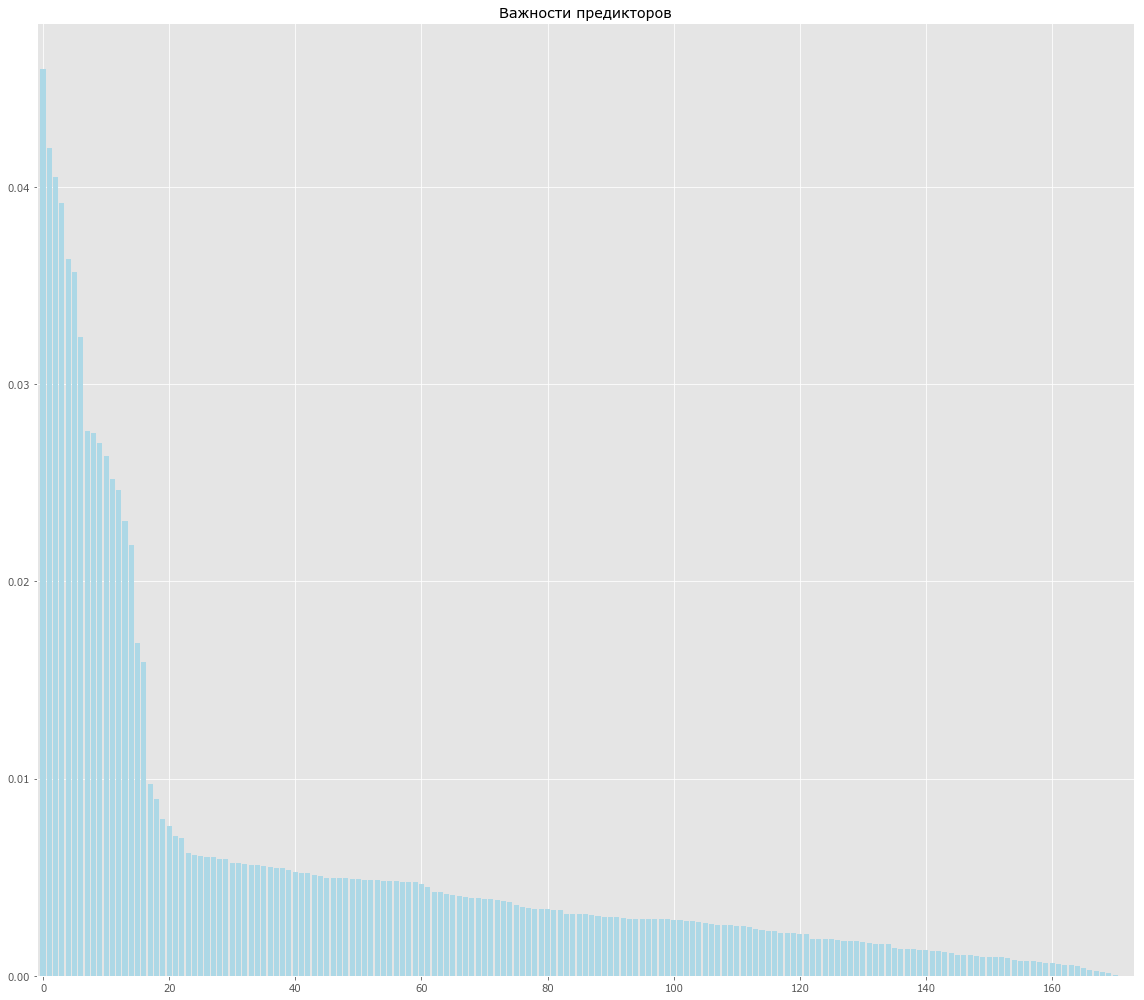

In [145]:
fig, ax = plt.subplots(figsize=(16, 14))

plt.title('Важности предикторов')
plt.bar(range(Xtrain.shape[1]), importances[indices],
              color='lightblue', align='center')

plt.xlim([-1, Xtrain.shape[1]])
plt.tight_layout()
plt.show()

In [146]:
pred_forest = forest.predict(Xtest)
confusion = confusion_matrix(ytest, pred_forest)
print("Матрица ошибок:\n{}".format(confusion))

Матрица ошибок:
[[2829    0]
 [ 368    0]]


In [147]:
print(classification_report(ytest, pred_forest,
                            target_names=["Не откликнулся", "Откликнулся"]))

                precision    recall  f1-score   support

Не откликнулся       0.88      1.00      0.94      2829
   Откликнулся       0.00      0.00      0.00       368

   avg / total       0.78      0.88      0.83      3197



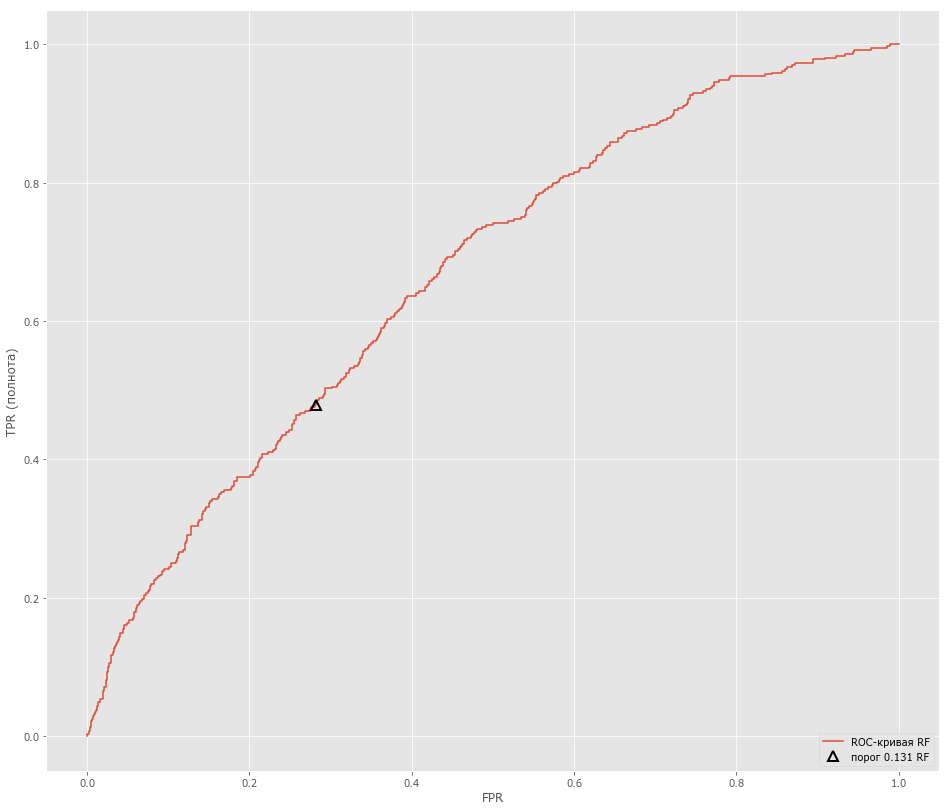

In [148]:
fig, ax = plt.subplots(figsize=(16, 14))

# Из модуля sklearn.metrics импортируем функцию roc_curve

# Вычисляем значения FPR и TPR для всех возможных порогов отсечения, передав функции 
# roc_curve в качестве аргументов фактические значения зависимой переменной, 
# записанные в y_control, и вероятности положительного класса, вычисленные 
# с помощью метода predict_proba
fpr_rf, tpr_rf, thresholds_rf = roc_curve(ytest, forest.predict_proba(Xtest)[:, 1])

# Создаем заголовок ROC-кривой
plt.plot(fpr_rf, tpr_rf, label="ROC-кривая RF")
# Задаем название для оси x
plt.xlabel("FPR")
# Задаем название для оси y
plt.ylabel("TPR (полнота)")
# Задаем порог отсечения по умолчанию 0.5
close_default_rf = np.argmin(np.abs(thresholds_rf-0.131))
# Строим ROC-кривую и наносим порог отсечения 0.5
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
         label="порог 0.131 RF", fillstyle="none", c='k', mew=2)
# Задаем расположение легенды
plt.legend(loc=4)

## Логистическая регрессия

### Условия

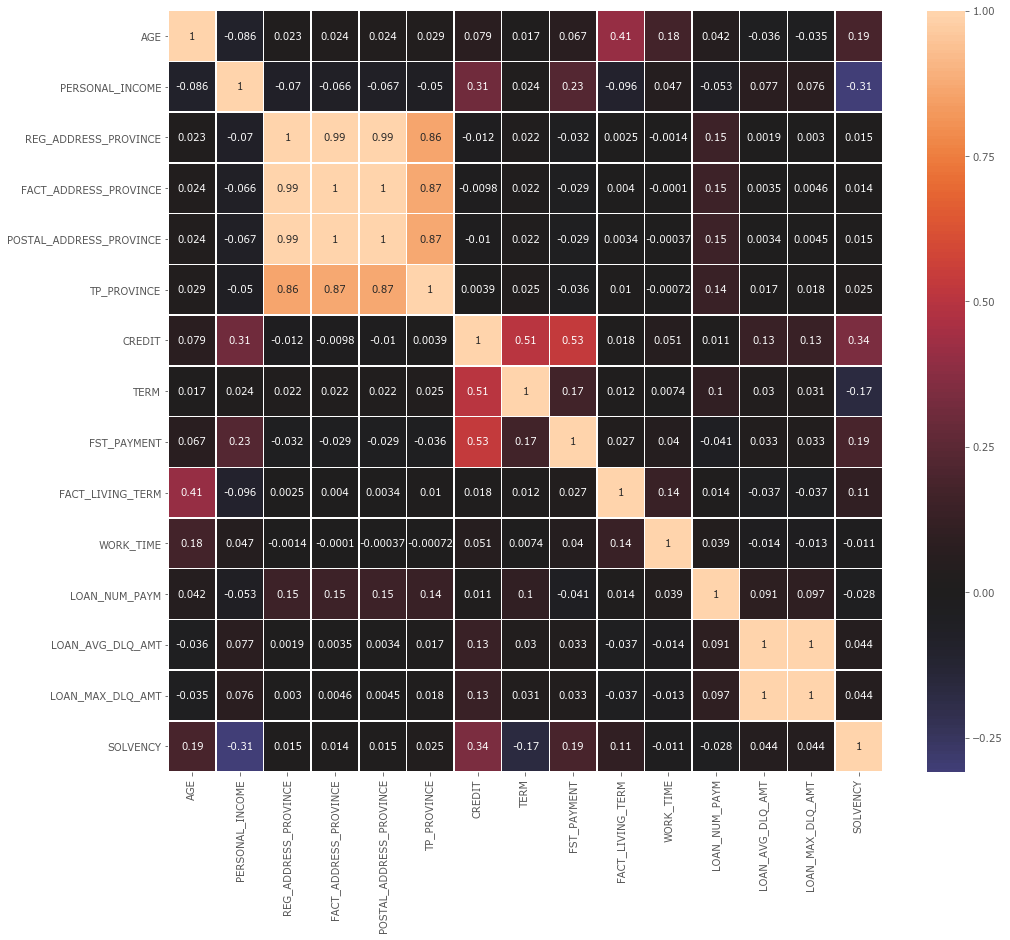

In [149]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(train_data.corr(), center=0, annot=True, linewidths=.5)

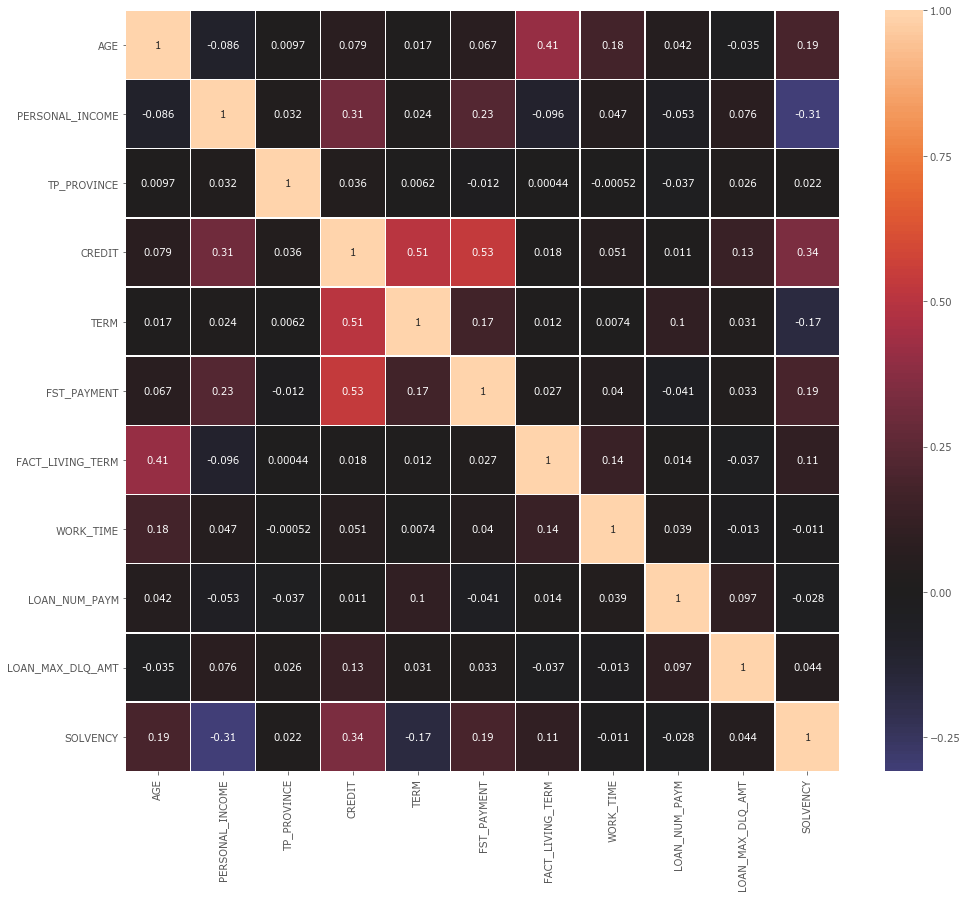

In [150]:
to_drop = ['FACT_ADDRESS_PROVINCE', 'LOAN_AVG_DLQ_AMT', 'REG_ADDRESS_PROVINCE']
tmp_data = train_data.drop(to_drop, axis=1)
tmp_data['TP_PROVINCE'] = tmp_data['TP_PROVINCE']/tmp_data['POSTAL_ADDRESS_PROVINCE']
tmp_data = tmp_data.drop('POSTAL_ADDRESS_PROVINCE', axis=1)
fig, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(tmp_data.corr(), center=0, annot=True, linewidths=.5)

In [151]:
to_drop = ['FACT_ADDRESS_PROVINCE', 'LOAN_AVG_DLQ_AMT', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE']
tmp_data = train_data.drop(to_drop, axis=1)
tmp_data['TP_PROVINCE'] = tmp_data['TP_PROVINCE']/tmp_data['REG_ADDRESS_PROVINCE']

In [152]:
tmp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Data columns (total 48 columns):
TARGET                        10656 non-null object
AGE                           10656 non-null int64
SOCSTATUS_WORK_FL             10656 non-null object
SOCSTATUS_PENS_FL             10656 non-null object
GENDER                        10656 non-null object
CHILD_TOTAL                   10656 non-null object
DEPENDANTS                    10656 non-null object
EDUCATION                     10656 non-null object
MARITAL_STATUS                10656 non-null object
GEN_INDUSTRY                  10656 non-null object
GEN_TITLE                     10656 non-null object
ORG_TP_STATE                  10656 non-null object
ORG_TP_FCAPITAL               10656 non-null object
JOB_DIR                       10656 non-null object
FAMILY_INCOME                 10656 non-null object
PERSONAL_INCOME               10656 non-null float64
REG_ADDRESS_PROVINCE          10656 non-null int64
TP_PROVI

In [153]:
tmp_cats, tmp_nums = columns(tmp_data)

In [154]:
tmp_nums

['AGE',
 'PERSONAL_INCOME',
 'REG_ADDRESS_PROVINCE',
 'TP_PROVINCE',
 'CREDIT',
 'TERM',
 'FST_PAYMENT',
 'FACT_LIVING_TERM',
 'WORK_TIME',
 'LOAN_NUM_PAYM',
 'LOAN_MAX_DLQ_AMT',
 'SOLVENCY']

AGE


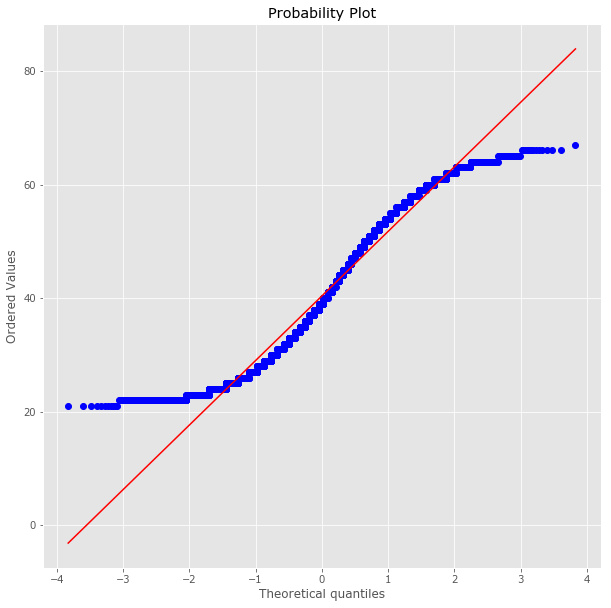

AGE ^1/3


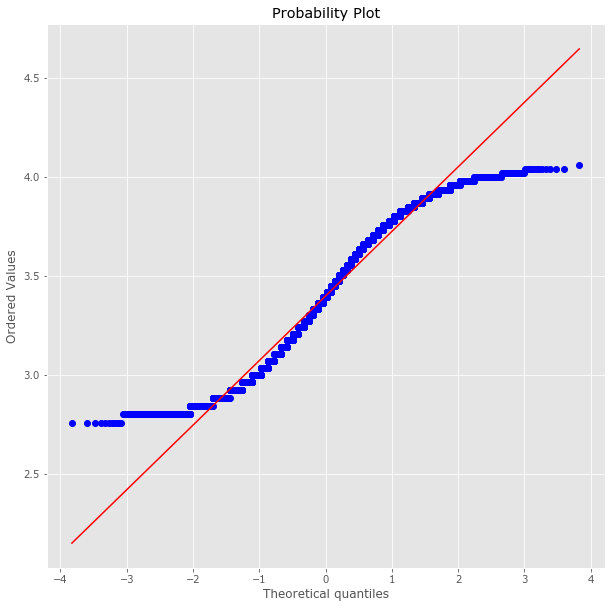


PERSONAL_INCOME


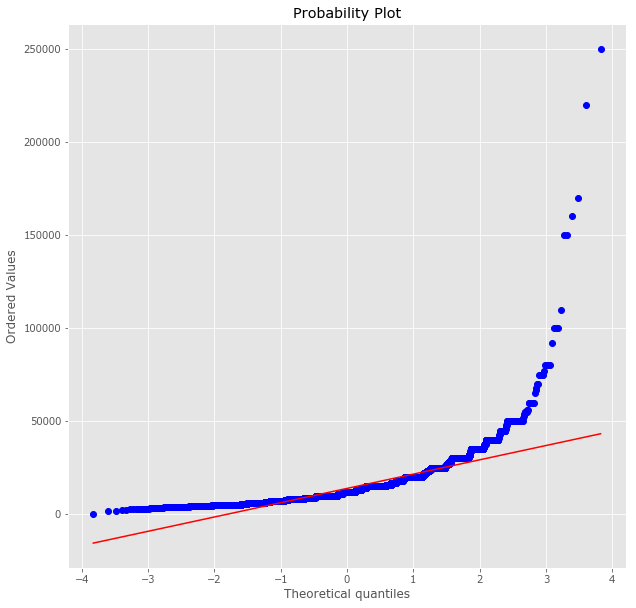

PERSONAL_INCOME ^1/3


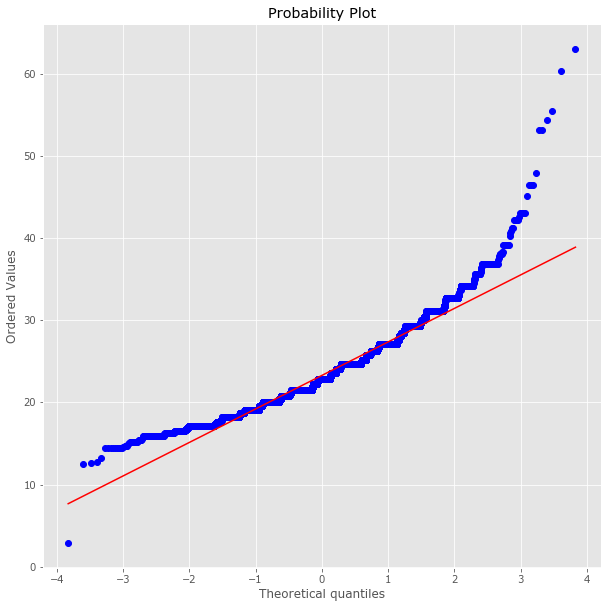


REG_ADDRESS_PROVINCE


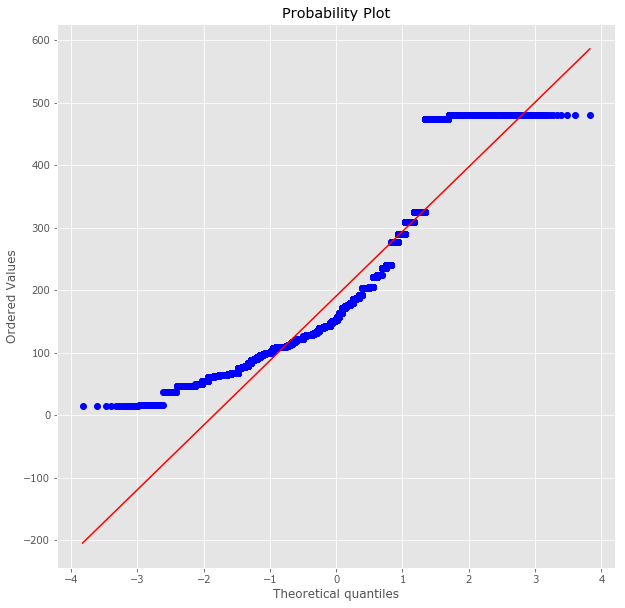

REG_ADDRESS_PROVINCE ^1/3


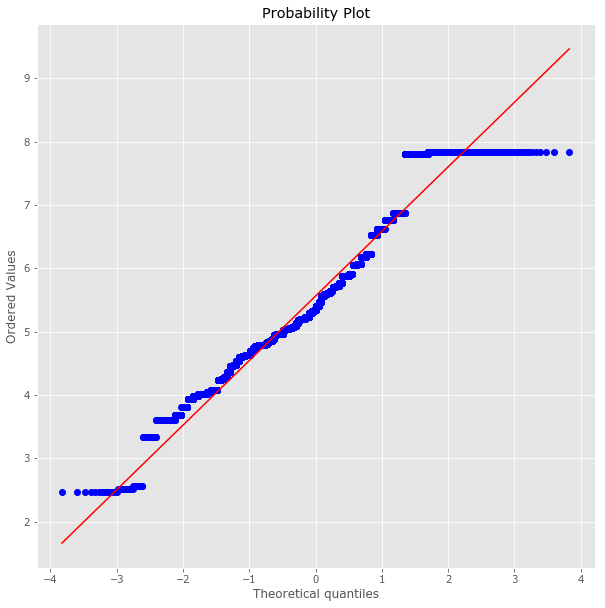


TP_PROVINCE


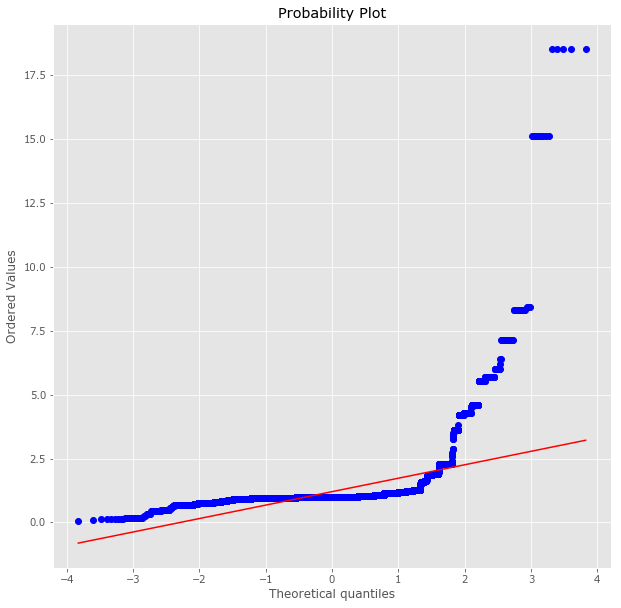

TP_PROVINCE ^1/3


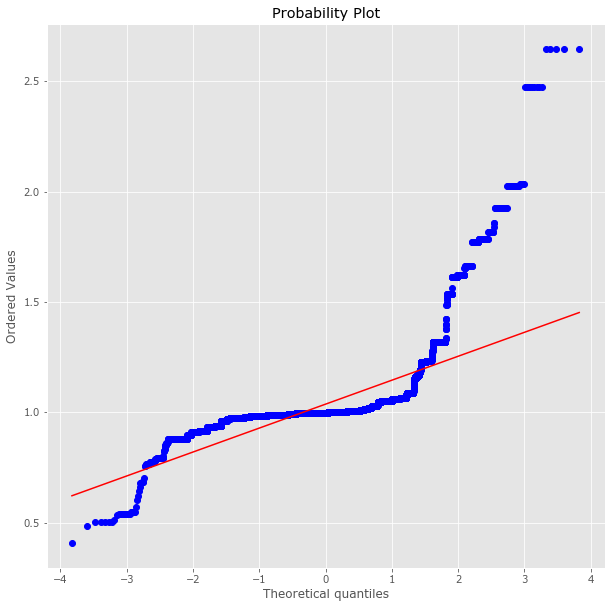


CREDIT


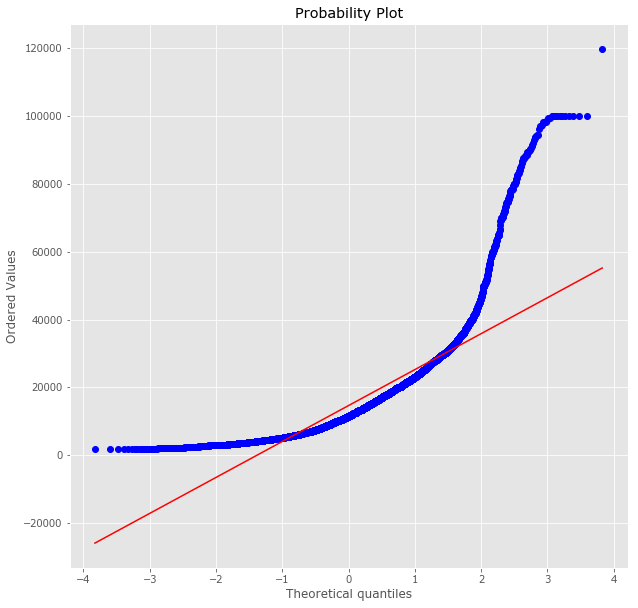

CREDIT ^1/3


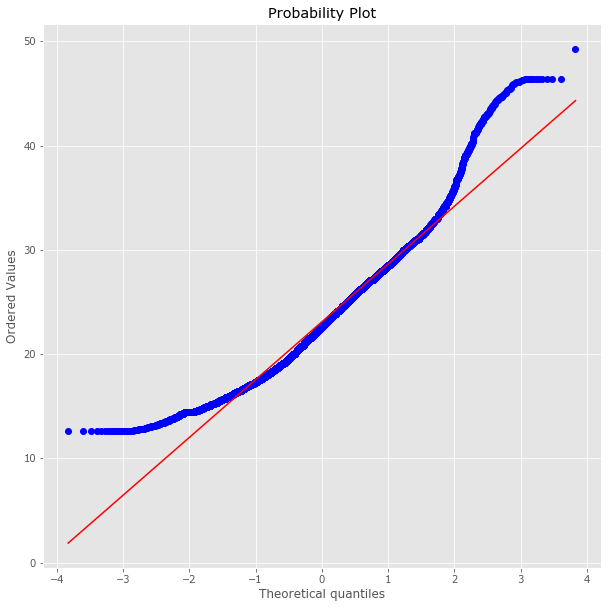


TERM


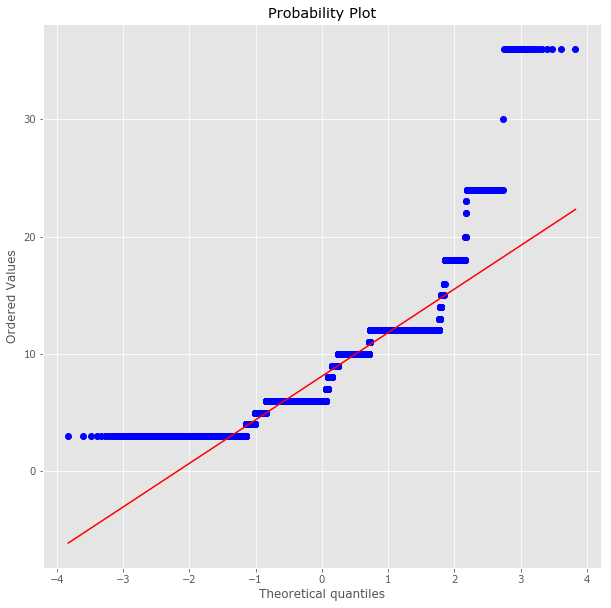

TERM ^1/3


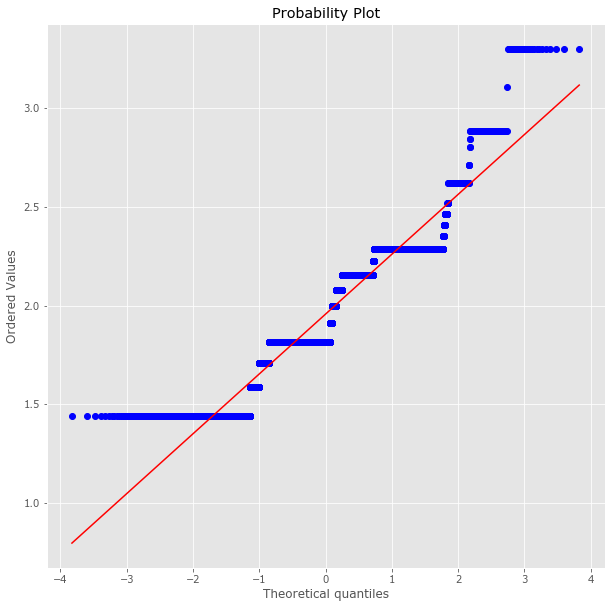


FST_PAYMENT


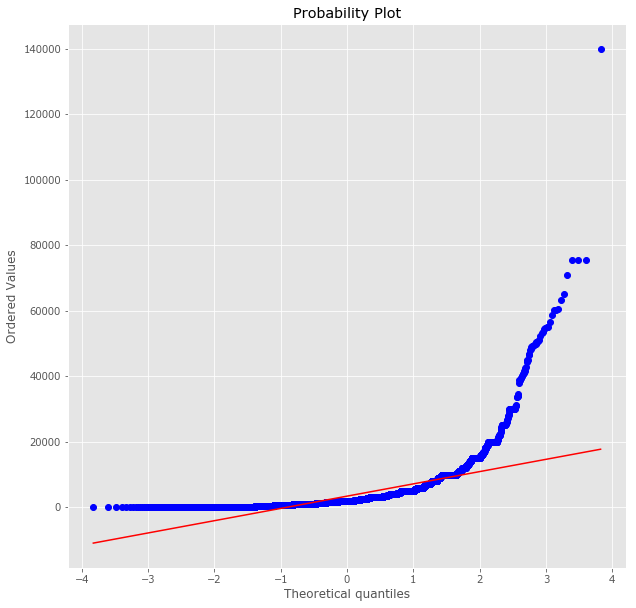

FST_PAYMENT ^1/3


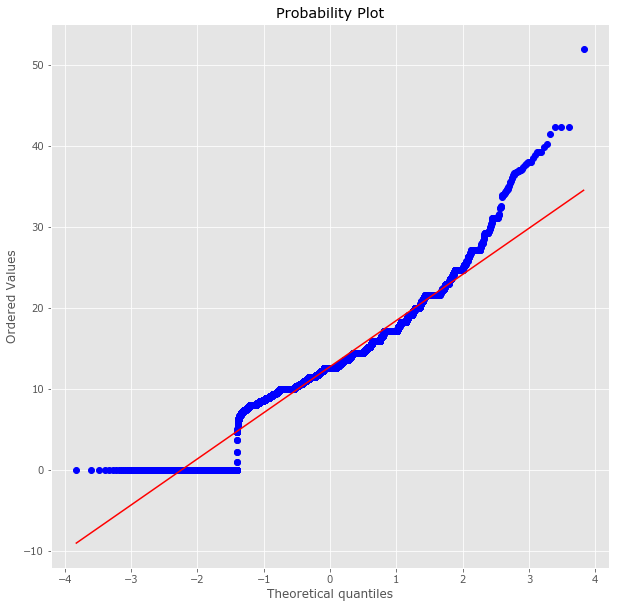


FACT_LIVING_TERM


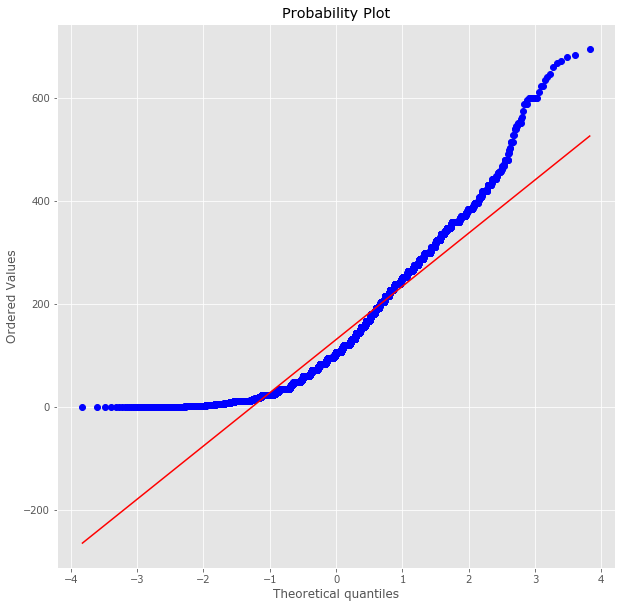

FACT_LIVING_TERM ^1/3


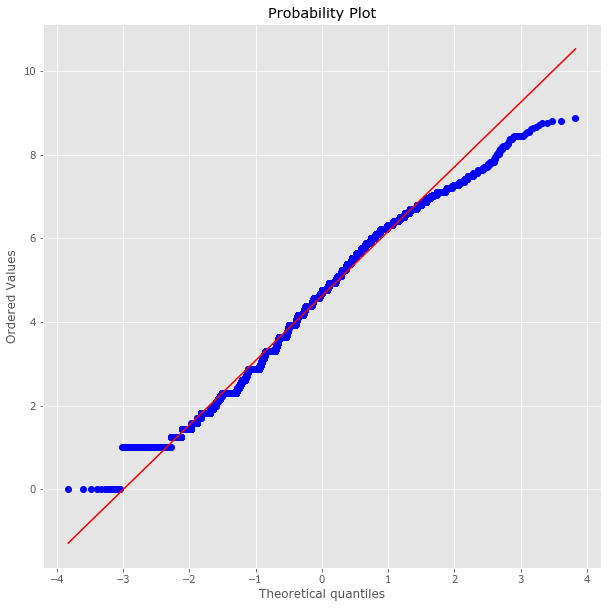


WORK_TIME


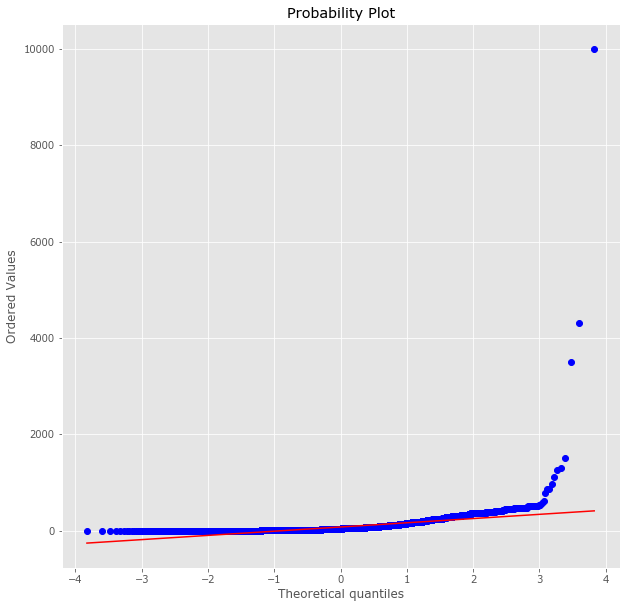

WORK_TIME ^1/3


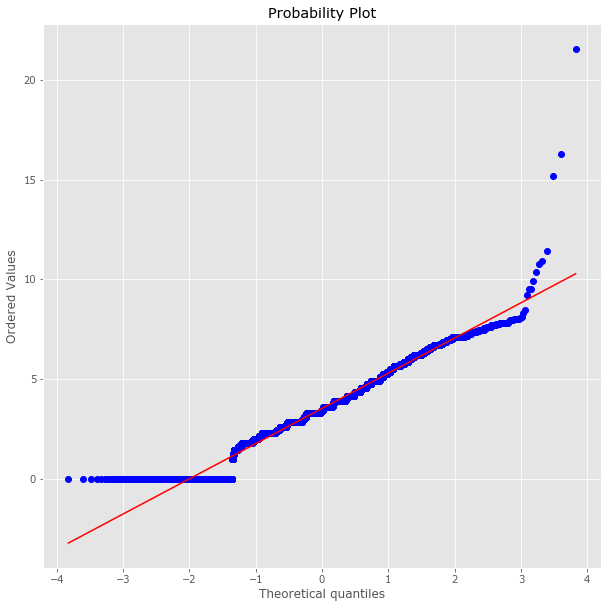


LOAN_NUM_PAYM


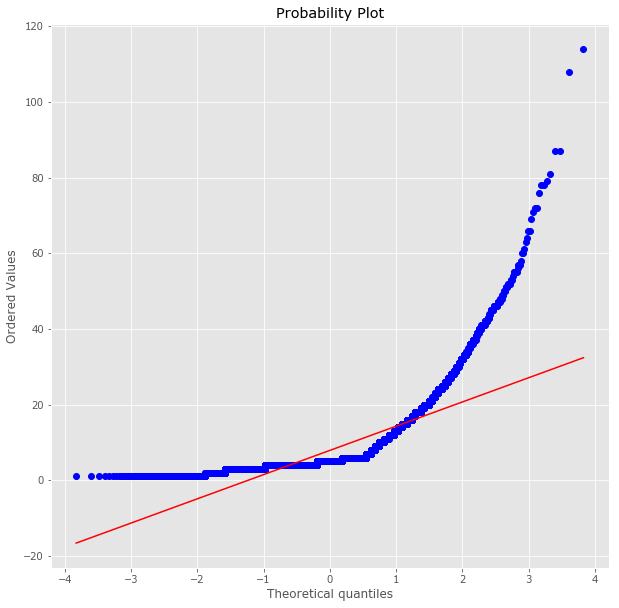

LOAN_NUM_PAYM ^1/3


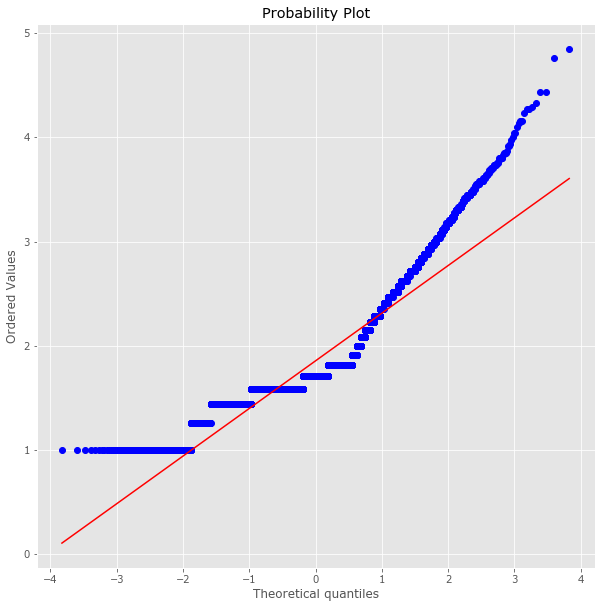


LOAN_MAX_DLQ_AMT


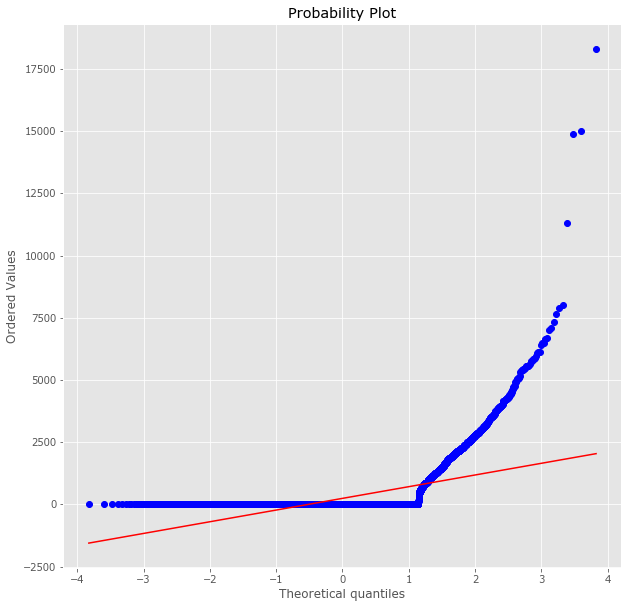

LOAN_MAX_DLQ_AMT ^1/3


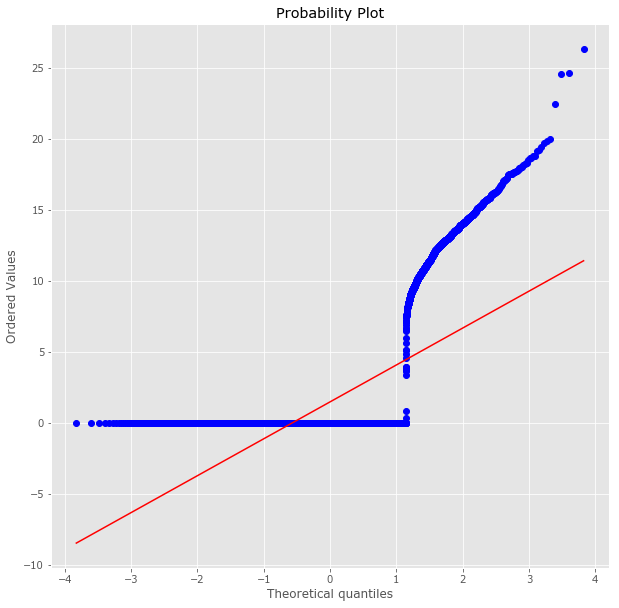


SOLVENCY


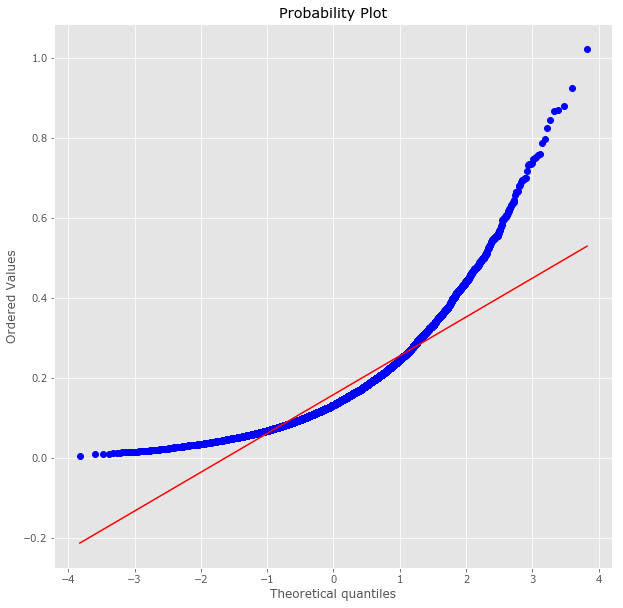

SOLVENCY ^1/3


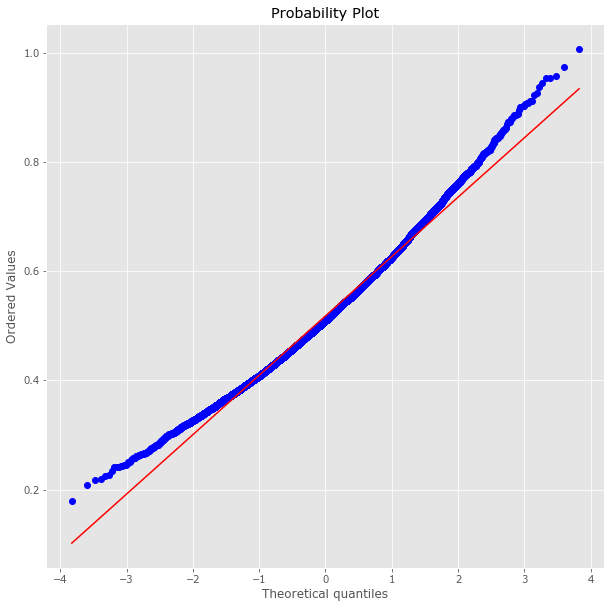

In [155]:
for col in tmp_nums:
    
    plt.subplots(figsize=(10, 10))
    print(col)

    stats.probplot(tmp_data[col], dist="norm", plot=plt)
    plt.show()
    
    plt.subplots(figsize=(10, 10))
    print(col, '^1/3')

    stats.probplot(tmp_data[col]**(1/3), dist="norm", plot=plt)
    plt.show()
    
    print()

In [162]:
def process_for_log_reg(train, test):
    
    def pre_proc(dataset):
    
        to_drop = ['FACT_ADDRESS_PROVINCE', 'LOAN_AVG_DLQ_AMT', 'FACT_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE']
        dataset = dataset.drop(to_drop, axis=1)
        dataset['TP_PROVINCE'] = dataset['TP_PROVINCE']/dataset['REG_ADDRESS_PROVINCE']


        dataset['PERSONAL_INCOME'] = dataset['PERSONAL_INCOME']**(1/3)
        dataset['REG_ADDRESS_PROVINCE'] = dataset['REG_ADDRESS_PROVINCE']**(1/3)

        dataset['CREDIT'] = dataset['CREDIT']**(1/3)
        dataset['TERM'] = dataset['TERM']**(1/3)

        dataset['FST_PAYMENT'] = dataset['FST_PAYMENT']**(1/3)
        dataset['FACT_LIVING_TERM'] = dataset['FACT_LIVING_TERM']**(1/3)

        dataset['WORK_TIME'] = dataset['WORK_TIME']**(1/3)
        dataset['LOAN_NUM_PAYM'] = dataset['LOAN_NUM_PAYM']**(1/3)

        dataset['TP_PROVINCE'] = dataset['TP_PROVINCE']**(1/3)
        dataset['SOLVENCY'] = dataset['SOLVENCY']**(1/3)


        dataset['PERSONAL_INCOME'][dataset['PERSONAL_INCOME'] == np.inf] = 1
        dataset['REG_ADDRESS_PROVINCE'][dataset['REG_ADDRESS_PROVINCE'] == np.inf] = 1

        dataset['CREDIT'][dataset['CREDIT'] == np.inf] = 1
        dataset['TERM'][dataset['TERM'] == np.inf] = 1

        dataset['FST_PAYMENT'][dataset['FST_PAYMENT'] == np.inf] = 1
        dataset['FACT_LIVING_TERM'][dataset['FACT_LIVING_TERM'] == np.inf] = 1

        dataset['WORK_TIME'][dataset['WORK_TIME'] == np.inf] = 1
        dataset['LOAN_NUM_PAYM'][dataset['LOAN_NUM_PAYM'] == np.inf] = 1

        dataset['TP_PROVINCE'][dataset['TP_PROVINCE'] == np.inf] = 1
        dataset['SOLVENCY'][dataset['SOLVENCY'] == np.inf] = 1

        dataset.drop('LOAN_MAX_DLQ_AMT', axis=1, inplace=True)
    
        return dataset
    
    train = pre_proc(train)
    test = pre_proc(test)
    
    cats, nums = columns(train)
    
    for i in nums:
        
        scaler = MinMaxScaler()
        scaler = scaler.fit(train.loc[:, i].reshape(-1, 1))
        train[i] = scaler.transform(train.loc[:, i].reshape(-1, 1))
        test[i] = scaler.transform(test.loc[:, i].reshape(-1, 1))
        
    train_dummy = pd.get_dummies(train)
    test_dummy = pd.get_dummies(test)
    
    return train_dummy, test_dummy, cats, nums

In [163]:
log_reg = LogisticRegression(n_jobs=-1)

In [164]:
logreg_train, logreg_test, cats_log, nums_log = process_for_log_reg(train_data, test_data)

In [165]:
logreg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Columns: 171 entries, AGE to DELAY_1
dtypes: float64(11), uint8(160)
memory usage: 2.5 MB


In [166]:
Xtrain_lg, Xtest_lg, ytrain_lg, ytest_lg = train_test_split(logreg_train.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                            logreg_train.loc[:, 'TARGET_1'], test_size=0.3)

In [167]:
Xtrain_lg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7459 entries, 8164 to 6628
Columns: 169 entries, AGE to DELAY_1
dtypes: float64(11), uint8(158)
memory usage: 1.8 MB


In [168]:
Xtest_lg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 5442 to 5719
Columns: 169 entries, AGE to DELAY_1
dtypes: float64(11), uint8(158)
memory usage: 793.0 KB


In [169]:
logreg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Columns: 171 entries, AGE to DELAY_1
dtypes: float64(11), uint8(160)
memory usage: 2.5 MB


In [170]:
log_reg.fit(Xtrain_lg, ytrain_lg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [171]:
X_log = logreg_test.drop(['TARGET_0', 'TARGET_1'], axis=1)
y_log = logreg_test.loc[:, 'TARGET_1']

In [172]:
roc_auc_score(y_log, log_reg.predict_proba(X_log)[:, 1])

0.6957636219250276

## H2O

### Случайный лес

In [173]:
import h2o
import os
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9h/3gqt7h5d5kz_gprfvv54xv000000gn/T/tmp7mz_7vz6
  JVM stdout: /var/folders/9h/3gqt7h5d5kz_gprfvv54xv000000gn/T/tmp7mz_7vz6/h2o_boriszubarev_started_from_python.out
  JVM stderr: /var/folders/9h/3gqt7h5d5kz_gprfvv54xv000000gn/T/tmp7mz_7vz6/h2o_boriszubarev_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,09 secs
H2O cluster timezone:,Asia/Yekaterinburg
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.4
H2O cluster version age:,"14 days, 4 hours and 54 minutes"
H2O cluster name:,H2O_from_python_boriszubarev_u7xbp0
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


In [174]:
Xtr, Xts, ytr, yts = train_test_split(train_data.drop('TARGET', axis=1), 
                                      train_data.loc[:, 'TARGET'], test_size=0.3)

In [175]:
training = h2o.H2OFrame(train_data)
validation = h2o.H2OFrame(test_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [176]:
cats, nums = columns(train_data)

In [177]:
for i in cats:
    
    training[i] = training[i].asfactor()
    validation[i] = validation[i].asfactor()

In [178]:
X_col = list(Xtr.columns)
y_col = 'TARGET'

In [179]:
from h2o.estimators import H2ORandomForestEstimator

In [180]:
rf = H2ORandomForestEstimator(model_id='RF_OTP', ntrees=500, max_depth=9, score_tree_interval=100, seed=42)

In [181]:
rf.train(X_col, y_col, training_frame=training, validation_frame=validation)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [182]:
rf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  RF_OTP


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1000368752302138
RMSE: 0.3162860655011754
LogLoss: 0.34373807193836564
Mean Per-Class Error: 0.36170102779298186
AUC: 0.679747080824667
Gini: 0.3594941616493339
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14129986020609828: 


,0,1,Error,Rate
0,7151.0,2245.0,0.2389,(2245.0/9396.0)
1,642.0,618.0,0.5095,(642.0/1260.0)
Total,7793.0,2863.0,0.2709,(2887.0/10656.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1412999,0.2997817,191.0
max f2,0.1036508,0.4476121,259.0
max f0point5,0.1775154,0.2484159,140.0
max accuracy,0.4887899,0.8816629,0.0
max precision,0.3931783,0.4545455,7.0
max recall,0.0131117,1.0,397.0
max specificity,0.4887899,0.9998936,0.0
max absolute_mcc,0.1412999,0.1832352,191.0
max min_per_class_accuracy,0.1222771,0.6311196,224.0
max mean_per_class_accuracy,0.1161623,0.6382990,237.0


Gains/Lift Table: Avg response rate: 11,82 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100413,0.3108310,2.5292390,2.5292390,0.2990654,0.2990654,0.0253968,0.0253968,152.9238985,152.9238985
,2,0.0200826,0.2804784,2.2921228,2.4106809,0.2710280,0.2850467,0.0230159,0.0484127,129.2122830,141.0680908
,3,0.0300300,0.2589618,2.5530997,2.4578571,0.3018868,0.290625,0.0253968,0.0738095,155.3099730,145.7857143
,4,0.0400713,0.2441166,1.5807744,2.2380729,0.1869159,0.2646370,0.0158730,0.0896825,58.0774366,123.8072934
,5,0.0500188,0.2331381,2.9520216,2.3800590,0.3490566,0.2814259,0.0293651,0.1190476,195.2021563,138.0058965
,6,0.1000375,0.1927289,1.8723131,2.1261860,0.2213884,0.2514071,0.0936508,0.2126984,87.2313053,112.6186009
,7,0.1500563,0.1706121,1.6501742,1.9675154,0.1951220,0.2326454,0.0825397,0.2952381,65.0174216,96.7515411
,8,0.2000751,0.1560905,1.7453766,1.9119807,0.2063790,0.2260788,0.0873016,0.3825397,74.5376575,91.1980702
,9,0.3000188,0.1361148,1.4134943,1.7459225,0.1671362,0.2064435,0.1412698,0.5238095,41.3494299,74.5922517
,10,0.4000563,0.1220768,1.1027607,1.5850943,0.1303940,0.1874267,0.1103175,0.6341270,10.2760654,58.5094333




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.10142302375464317
RMSE: 0.3184698160809642
LogLoss: 0.3457429408243457
Mean Per-Class Error: 0.3565632501308499
AUC: 0.690269731261393
Gini: 0.38053946252278603
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.134630460417519: 


,0,1,Error,Rate
0,2865.0,1150.0,0.2864,(1150.0/4015.0)
1,250.0,302.0,0.4529,(250.0/552.0)
Total,3115.0,1452.0,0.3065,(1400.0/4567.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1346305,0.3013972,197.0
max f2,0.0949602,0.4648901,278.0
max f0point5,0.1702100,0.2529940,137.0
max accuracy,0.4813551,0.8793519,0.0
max precision,0.4813551,1.0,0.0
max recall,0.0238678,1.0,388.0
max specificity,0.4813551,1.0,0.0
max absolute_mcc,0.1199352,0.1894177,226.0
max min_per_class_accuracy,0.1226090,0.6348692,220.0
max mean_per_class_accuracy,0.1105723,0.6434367,247.0


Gains/Lift Table: Avg response rate: 12,09 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100723,0.3008443,2.8777568,2.8777568,0.3478261,0.3478261,0.0289855,0.0289855,187.7756774,187.7756774
,2,0.0201445,0.2774326,3.0576166,2.9676867,0.3695652,0.3586957,0.0307971,0.0597826,205.7616572,196.7686673
,3,0.0299978,0.2564806,1.6547101,2.5364170,0.2,0.3065693,0.0163043,0.0760870,65.4710145,153.6417010
,4,0.0400701,0.2430592,2.8777568,2.6222183,0.3478261,0.3169399,0.0289855,0.1050725,187.7756774,162.2218262
,5,0.0501423,0.2308311,2.1583176,2.5290330,0.2608696,0.3056769,0.0217391,0.1268116,115.8317580,152.9032973
,6,0.1000657,0.1914223,1.5240751,2.0276536,0.1842105,0.2450766,0.0760870,0.2028986,52.4075133,102.7653569
,7,0.1499891,0.1708389,1.8506627,1.9687427,0.2236842,0.2379562,0.0923913,0.2952899,85.0662662,96.8742727
,8,0.2001314,0.1575232,1.5896779,1.8737691,0.1921397,0.2264770,0.0797101,0.375,58.9677868,87.3769147
,9,0.2999781,0.1369023,1.4152126,1.7211401,0.1710526,0.2080292,0.1413043,0.5163043,41.5212624,72.1140114
,10,0.4000438,0.1220374,1.2672835,1.6076139,0.1531729,0.1943076,0.1268116,0.6431159,26.7283481,60.7613852



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-03-23 00:10:35,0.207 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2018-03-23 00:10:37,2.580 sec,100.0,0.3166292,0.3446164,0.6717875,2.6873164,0.3350225,0.3185598,0.3455485,0.6904191,2.8777568,0.3078607
,2018-03-23 00:10:38,4.025 sec,200.0,0.3164472,0.3441028,0.6762107,2.5292390,0.2874437,0.3186573,0.3459285,0.6899717,2.5180372,0.2988833
,2018-03-23 00:10:40,5.410 sec,300.0,0.3164339,0.3441210,0.6787802,2.2921228,0.2728979,0.3185246,0.3456426,0.6910846,3.0576166,0.3724546
,2018-03-23 00:10:41,6.760 sec,400.0,0.3163924,0.3439989,0.6791401,2.2921228,0.2741179,0.3185238,0.3457504,0.6904335,3.0576166,0.3700460
,2018-03-23 00:10:43,8.236 sec,500.0,0.3162861,0.3437381,0.6797471,2.5292390,0.2709272,0.3184698,0.3457429,0.6902697,2.8777568,0.3065470


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
GEN_INDUSTRY,9142.2753906,1.0,0.1215227
REGION_NM,5728.1708984,0.6265586,0.0761411
AGE,4131.6113281,0.4519237,0.0549190
GEN_TITLE,3825.3994141,0.4184297,0.0508487
SOLVENCY,3125.7199707,0.3418974,0.0415483
---,---,---,---
REG_PHONE_FL,216.6041565,0.0236926,0.0028792
SOCSTATUS_WORK_FL,193.9026794,0.0212095,0.0025774
FACT_POST_FL,177.5091095,0.0194163,0.0023595
GAR_PRESENCE_FL,149.6170197,0.0163654,0.0019888



See the whole table with table.as_data_frame()


### Логистическая регрессия

In [183]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [184]:
glm = H2OGeneralizedLinearEstimator(model_id='LogReg_OTP', seed=42)

In [185]:
training_log = h2o.H2OFrame(logreg_train)
validation_log = h2o.H2OFrame(logreg_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [186]:
logreg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10656 entries, 0 to 10655
Columns: 171 entries, AGE to DELAY_1
dtypes: float64(11), uint8(160)
memory usage: 2.5 MB


In [187]:
categorical_columns = [col for col in logreg_train.columns if logreg_train[col].dtype.name == 'uint8']
numerical_columns = [col for col in logreg_train.columns if logreg_train[col].dtype.name != 'uint8']

In [188]:
for i in categorical_columns:
    
    training_log[i] = training_log[i].asfactor()
    validation_log[i] = validation_log[i].asfactor()

In [189]:
X_log_col = list(Xtrain_lg.columns)
y_log_col = 'TARGET_1'

In [190]:
training_log.describe()

Rows:10657
Cols:171




,AGE,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,TP_PROVINCE,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_PAYM,SOLVENCY,TARGET_0,TARGET_1,SOCSTATUS_WORK_FL_0,SOCSTATUS_WORK_FL_1,SOCSTATUS_PENS_FL_0,SOCSTATUS_PENS_FL_1,GENDER_0,GENDER_1,CHILD_TOTAL_0,CHILD_TOTAL_1,CHILD_TOTAL_2,CHILD_TOTAL_3,CHILD_TOTAL_4,DEPENDANTS_0,DEPENDANTS_1,DEPENDANTS_2,DEPENDANTS_3,DEPENDANTS_4,EDUCATION_Высшее,EDUCATION_Неоконченное высшее,EDUCATION_Неполное среднее,EDUCATION_Среднее,EDUCATION_Среднее специальное,MARITAL_STATUS_Вдовец/Вдова,MARITAL_STATUS_Гражданский брак,MARITAL_STATUS_Не состоял в браке,MARITAL_STATUS_Разведен(а),MARITAL_STATUS_Состою в браке,GEN_INDUSTRY_nan,GEN_INDUSTRY_Банк/Финансы,GEN_INDUSTRY_Государственная служба,GEN_INDUSTRY_Другие сферы,GEN_INDUSTRY_Здравоохранение,GEN_INDUSTRY_Информационные технологии,GEN_INDUSTRY_Информационные услуги,GEN_INDUSTRY_Коммунальное хоз-во/Дорожные службы,GEN_INDUSTRY_Металлургия/Промышленность/Машиностроение,GEN_INDUSTRY_Наука,GEN_INDUSTRY_Нефтегазовая промышленность,GEN_INDUSTRY_Образование,GEN_INDUSTRY_Развлечения/Искусство,GEN_INDUSTRY_Ресторанный бизнес/Общественное питание,GEN_INDUSTRY_СМИ/Реклама/PR-агенства,GEN_INDUSTRY_Салоны красоты и здоровья,GEN_INDUSTRY_Сборочные производства,GEN_INDUSTRY_Сельское хозяйство,GEN_INDUSTRY_Страхование,GEN_INDUSTRY_Строительство,GEN_INDUSTRY_Торговля,GEN_INDUSTRY_Транспорт,GEN_INDUSTRY_Химия/Парфюмерия/Фармацевтика,GEN_INDUSTRY_ЧОП/Детективная д-ть,GEN_INDUSTRY_Энергетика,GEN_INDUSTRY_Юридические услуги/нотариальные услуги,GEN_TITLE_nan,GEN_TITLE_Военнослужащий по контракту,GEN_TITLE_Высококвалифиц. специалист,GEN_TITLE_Другое,GEN_TITLE_Индивидуальный предприниматель,GEN_TITLE_Партнер,GEN_TITLE_Работник сферы услуг,GEN_TITLE_Рабочий,GEN_TITLE_Руководитель высшего звена,GEN_TITLE_Руководитель низшего звена,GEN_TITLE_Руководитель среднего звена,GEN_TITLE_Служащий,GEN_TITLE_Специалист,ORG_TP_STATE_nan,ORG_TP_STATE_Государственная комп./учреж.,ORG_TP_STATE_Индивидуальный предприниматель,ORG_TP_STATE_Некоммерческая организация,ORG_TP_STATE_Частная компания,ORG_TP_FCAPITAL_nan,ORG_TP_FCAPITAL_Без участия,ORG_TP_FCAPITAL_С участием,JOB_DIR_nan,JOB_DIR_Адм-хоз. и трансп. службы,"JOB_DIR_Бухгалтерия, финансы, планир.",JOB_DIR_Вспомогательный техперсонал,JOB_DIR_Кадровая служба и секретариат,JOB_DIR_Пр-техн. обесп. и телеком.,JOB_DIR_Служба безопасности,JOB_DIR_Снабжение и сбыт,JOB_DIR_Участие в основ. деятельности,JOB_DIR_Юридическая служба,FAMILY_INCOME_до 5000 руб.,FAMILY_INCOME_от 10000 до 20000 руб.,FAMILY_INCOME_от 20000 до 50000 руб.,FAMILY_INCOME_от 5000 до 10000 руб.,FAMILY_INCOME_свыше 50000 руб.,REGION_NM_ВОСТОЧНО-СИБИРСКИЙ,REGION_NM_ДАЛЬНЕВОСТОЧНЫЙ,REGION_NM_ЗАПАДНО-СИБИРСКИЙ,REGION_NM_ПОВОЛЖСКИЙ,REGION_NM_ПРИВОЛЖСКИЙ,REGION_NM_СЕВЕРО-ЗАПАДНЫЙ,REGION_NM_УРАЛЬСКИЙ,REGION_NM_ЦЕНТРАЛЬНЫЙ 1,REGION_NM_ЦЕНТРАЛЬНЫЙ 2,REGION_NM_ЦЕНТРАЛЬНЫЙ ОФИС,REGION_NM_ЮЖНЫЙ,REG_FACT_FL_0,REG_FACT_FL_1,FACT_POST_FL_0,FACT_POST_FL_1,REG_POST_FL_0,REG_POST_FL_1,REG_FACT_POST_FL_0,REG_FACT_POST_FL_1,REG_FACT_POST_TP_FL_0,REG_FACT_POST_TP_FL_1,FL_PRESENCE_FL_0,FL_PRESENCE_FL_1,OWN_AUTO_0,OWN_AUTO_1,AUTO_RUS_FL_0,AUTO_RUS_FL_1,HS_PRESENCE_FL_0,HS_PRESENCE_FL_1,COT_PRESENCE_FL_0,COT_PRESENCE_FL_1,GAR_PRESENCE_FL_0,GAR_PRESENCE_FL_1,LAND_PRESENCE_FL_0,LAND_PRESENCE_FL_1,GPF_DOCUMENT_FL_0,GPF_DOCUMENT_FL_1,FACT_PHONE_FL_0,FACT_PHONE_FL_1,REG_PHONE_FL_0,REG_PHONE_FL_1,GEN_PHONE_FL_0,GEN_PHONE_FL_1,LOAN_NUM_TOTAL_1,LOAN_NUM_TOTAL_2,LOAN_NUM_TOTAL_3,LOAN_NUM_TOTAL_4,LOAN_NUM_TOTAL_5,LOAN_NUM_TOTAL_6,LOAN_NUM_TOTAL_7,LOAN_NUM_CLOSED_0,LOAN_NUM_CLOSED_1,LOAN_NUM_CLOSED_2,LOAN_NUM_CLOSED_3,LOAN_NUM_CLOSED_4,LOAN_NUM_CLOSED_5,LOAN_NUM_CLOSED_6,LOAN_NUM_CLOSED_7,LOAN_DLQ_NUM_0,LOAN_DLQ_NUM_1,LOAN_DLQ_NUM_2,LOAN_DLQ_NUM_3,LOAN_DLQ_NUM_4,LOAN_DLQ_NUM_5,LOAN_DLQ_NUM_6,LOAN_DLQ_NUM_7,PREVIOUS_CARD_NUM_UTILIZED_0.0,PREVIOUS_CARD_NUM_UTILIZED_1.0,DELAY_0,DELAY_1
type,real,real,real,real,real,real,real,real,real,real,real,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,e

In [191]:
# разобраться в чем проблема
# glm.train(X_log_col, y_log_col, training_frame=training_log, validation_frame=validation_log)

In [192]:
glm

No model trained yet


### Градиентный бустинг

In [193]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [194]:
gbm_data = pd.concat([train_data, test_data])
gbm_data.reset_index(inplace=True)
gbm_data.drop('index', axis=1, inplace=True)
gbm_data.to_csv('data/data_for_h2o_gbm.csv', encoding='utf-8')

In [195]:
gbm_data = h2o.import_file('data/data_for_h2o_gbm.csv')
gbm_data = gbm_data.drop('C1')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [196]:
gbm_data.head()

TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,DELAY,SOLVENCY
0,35,1,0,0,1,1,Среднее,Состою в браке,ЧОП/Детективная д-ть,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,12000,290,291,291,289,ДАЛЬНЕВОСТОЧНЫЙ,0,0,1,0,1,0,0,0,0,0,0,0,8857,10,3293,0,108,24,1,0,1,2,2,19,1,830,830,0,1,0.0738083
1,34,1,0,1,2,2,Среднее специальное,Состою в браке,Нефтегазовая промышленность,Высококвалифиц. специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,свыше 50000 руб.,35000,128,126,127,104,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,1,1,0,0,0,0,0,90000,24,30000,1,72,144,1,0,1,1,0,5,0,0,0,0,0,0.107143
0,33,1,0,1,3,3,Среднее,Состою в браке,Другие сферы,Служащий,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,141,142,142,109,УРАЛЬСКИЙ,1,1,1,1,1,0,1,1,1,0,0,0,4490,10,1000,1,139,6,1,0,1,4,3,34,2,560,560,0,1,0.0498889
0,61,1,1,1,0,0,Высшее,Состою в браке,Наука,Специалист,Государственная комп./учреж.,Без участия,"Бухгалтерия, финансы, планир.",от 20000 до 50000 руб.,20000,474,473,473,549,ЮЖНЫЙ,1,1,1,1,1,1,0,0,0,0,0,0,15740,7,1750,1,264,144,1,0,1,3,2,18,0,0,0,0,0,0.112429
0,26,1,0,0,0,0,Неоконченное высшее,Не состоял в браке,Металлургия/Промышленность/Машиностроение,Высококвалифиц. специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,158,154,156,156,ЦЕНТРАЛЬНЫЙ 1,0,1,0,0,1,0,1,1,0,0,0,0,7978,9,0,1,48,46,1,0,1,1,0,4,0,0,0,0,0,0.0738704
0,63,0,1,1,0,0,Среднее специальное,Не состоял в браке,nan,nan,nan,nan,nan,от 5000 до 10000 руб.,8000,99,102,102,75,ЮЖНЫЙ,1,1,1,1,1,1,0,0,0,0,0,0,10600,12,0,1,420,0,1,0,0,3,2,32,0,0,0,0,0,0.110417
0,40,1,0,1,0,0,Среднее специальное,Не состоял в браке,Металлургия/Промышленность/Машиностроение,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,15000,325,324,324,311,ЗАПАДНО-СИБИРСКИЙ,1,1,1,1,1,1,0,0,0,1,0,0,30340,12,5000,1,276,36,1,0,1,1,0,4,0,0,0,0,0,0.168556
0,32,1,0,1,1,1,Среднее,Разведен(а),Торговля,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,8000,180,180,180,231,ПРИВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,2389,3,300,0,112,3,0,0,1,1,1,2,0,0,0,0,0,0.0995417
0,27,1,0,1,2,2,Среднее специальное,Состою в браке,Здравоохранение,Рабочий,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,5000,63,60,62,62,ПРИВОЛЖСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,9251,6,3000,1,72,36,1,0,1,1,0,4,0,0,0,0,0,0.308367
0,62,1,1,1,2,0,Высшее,Не состоял в браке,Наука,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,16000,481,480,480,476,ЗАПАДНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,22286,8,0,0,24,12,1,0,1,3,3,24,0,0,0,0,0,0.174109


In [197]:
train, valid, test = gbm_data.split_frame(
    ratios=[0.6, 0.2], 
    seed=42, 
    destination_frames=['train.hex','valid.hex','test.hex']
)

In [198]:
for i in cats:
    
    train[i] = train[i].asfactor()
    valid[i] = valid[i].asfactor()
    test[i] = test[i].asfactor()

In [199]:
gbm = H2OGradientBoostingEstimator()
gbm.train(x=train.col_names, y='TARGET', training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [200]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1521745817335_12


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07217070680713622
RMSE: 0.2686460623332049
LogLoss: 0.25158535619885597
Mean Per-Class Error: 0.17582724630682067
AUC: 0.9103697060117113
Gini: 0.8207394120234226
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22004815828361243: 


,0,1,Error,Rate
0,7756.0,319.0,0.0395,(319.0/8075.0)
1,446.0,631.0,0.4141,(446.0/1077.0)
Total,8202.0,950.0,0.0836,(765.0/9152.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2200482,0.6225950,167.0
max f2,0.1582543,0.6754130,217.0
max f0point5,0.3029985,0.7050645,124.0
max accuracy,0.2760031,0.9230769,137.0
max precision,0.8627809,1.0,0.0
max recall,0.0334739,1.0,380.0
max specificity,0.8627809,1.0,0.0
max absolute_mcc,0.2256053,0.5788943,163.0
max min_per_class_accuracy,0.1403741,0.8225387,236.0
max mean_per_class_accuracy,0.1353599,0.8241728,242.0


Gains/Lift Table: Avg response rate: 11,77 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100524,0.5857279,8.4976787,8.4976787,1.0,1.0,0.0854225,0.0854225,749.7678737,749.7678737
,2,0.0201049,0.4747232,8.3129466,8.4053127,0.9782609,0.9891304,0.0835655,0.1689879,731.2946591,740.5312664
,3,0.0300481,0.4085391,7.8440111,8.2195729,0.9230769,0.9672727,0.0779944,0.2469824,684.4011142,721.9572888
,4,0.0401005,0.3527804,6.8350894,7.8725089,0.8043478,0.9264305,0.0687094,0.3156917,583.5089419,687.2508912
,5,0.0500437,0.3137852,5.9763894,7.4957690,0.7032967,0.8820961,0.0594243,0.3751161,497.6389442,649.5769017
,6,0.1000874,0.2232010,3.9705311,5.7331501,0.4672489,0.6746725,0.1987001,0.5738162,297.0531113,473.3150065
,7,0.1500219,0.1843148,2.3243104,4.5985253,0.2735230,0.5411508,0.1160631,0.6898793,132.4310377,359.8525347
,8,0.2000656,0.1593571,1.5399723,3.8334695,0.1812227,0.4511196,0.0770659,0.7669452,53.9972348,283.3469490
,9,0.3000437,0.1261091,1.0215789,2.8965139,0.1202186,0.3408594,0.1021356,0.8690808,2.1578865,189.6513947
,10,0.4000219,0.1035767,0.5850861,2.3188148,0.0688525,0.2728763,0.0584958,0.9275766,-41.4913923,131.8814821




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1017491513105053
RMSE: 0.3189814278457373
LogLoss: 0.34811909869306734
Mean Per-Class Error: 0.3701704804266366
AUC: 0.6736564742817728
Gini: 0.34731294856354555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13433107615449374: 


,0,1,Error,Rate
0,2024.0,683.0,0.2523,(683.0/2707.0)
1,182.0,187.0,0.4932,(182.0/369.0)
Total,2206.0,870.0,0.2812,(865.0/3076.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1343311,0.3018563,213.0
max f2,0.0757560,0.4537340,304.0
max f0point5,0.1515702,0.2531041,189.0
max accuracy,0.6988883,0.8800390,1.0
max precision,0.6988883,0.5,1.0
max recall,0.0285016,1.0,386.0
max specificity,0.7120230,0.9996306,0.0
max absolute_mcc,0.1343311,0.1835799,213.0
max min_per_class_accuracy,0.1067553,0.6178862,252.0
max mean_per_class_accuracy,0.1206034,0.6298295,232.0


Gains/Lift Table: Avg response rate: 12,00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100780,0.4075668,3.4957601,3.4957601,0.4193548,0.4193548,0.0352304,0.0352304,249.5760119,249.5760119
,2,0.0201560,0.3384031,2.6890462,3.0924032,0.3225806,0.3709677,0.0271003,0.0623306,168.9046245,209.2403182
,3,0.0302341,0.3024759,1.3445231,2.5097765,0.1612903,0.3010753,0.0135501,0.0758808,34.4523123,150.9776496
,4,0.0403121,0.2861584,2.1512370,2.4201416,0.2580645,0.2903226,0.0216802,0.0975610,115.1236996,142.0141621
,5,0.0500650,0.2760642,2.5008130,2.4358568,0.3,0.2922078,0.0243902,0.1219512,150.0813008,143.5856826
,6,0.1001300,0.2109110,1.3532538,1.8945553,0.1623377,0.2272727,0.0677507,0.1897019,35.3253792,89.4555309
,7,0.1501951,0.1819341,1.8404252,1.8765119,0.2207792,0.2251082,0.0921409,0.2818428,84.0425157,87.6511925
,8,0.2002601,0.1610866,1.7321649,1.8404252,0.2077922,0.2207792,0.0867209,0.3685637,73.2164854,84.0425157
,9,0.3000650,0.1290950,1.5477344,1.7430730,0.1856678,0.2091008,0.1544715,0.5230352,54.7734435,74.3072989
,10,0.4001951,0.1081332,0.8390174,1.5168755,0.1006494,0.1819659,0.0840108,0.6070461,-16.0982649,51.6875477



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-03-23 00:11:05,0.018 sec,0.0,0.3222279,0.3622753,0.5,1.0,0.8823208,0.3249239,0.3668722,0.5,1.0,0.8800390
,2018-03-23 00:11:05,0.299 sec,1.0,0.3196921,0.3553905,0.6762186,5.3588965,0.2581949,0.3241086,0.3644225,0.5976511,1.5156442,0.2799090
,2018-03-23 00:11:05,0.393 sec,2.0,0.3176588,0.3499955,0.7236691,6.4656251,0.1968969,0.3235529,0.3627946,0.6074150,2.1512370,0.2925878
,2018-03-23 00:11:05,0.498 sec,3.0,0.3157730,0.3452194,0.7429344,6.8350894,0.2086976,0.3228574,0.3607518,0.6284004,2.3445122,0.2548765
,2018-03-23 00:11:05,0.624 sec,4.0,0.3141564,0.3413222,0.7523061,6.8350894,0.1774476,0.3223384,0.3592474,0.6325050,1.6134277,0.2799090
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2018-03-23 00:11:08,2.806 sec,46.0,0.2708316,0.2552338,0.9066862,8.4976787,0.0874126,0.3188236,0.3478199,0.6737326,3.2268555,0.2854356
,2018-03-23 00:11:08,2.841 sec,47.0,0.2703926,0.2545107,0.9074587,8.4976787,0.0875219,0.3188829,0.3478828,0.6741075,3.2268555,0.2851105
,2018-03-23 00:11:08,2.879 sec,48.0,0.2697419,0.2534668,0.9081488,8.4976787,0.0866477,0.3189551,0.3479403,0.6744158,3.4957601,0.2825098
,2018-03-23 00:11:08,2.917 sec,49.0,0.2690658,0.2523009,0.9095547,8.4976787,0.0842439,0.3189193,0.3478701,0.6745870,3.4957601,0.2841352



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
GEN_INDUSTRY,313.0042114,1.0,0.2489139
REGION_NM,137.3152771,0.4387011,0.1091988
GEN_TITLE,90.3515091,0.2886591,0.0718513
SOLVENCY,69.3937683,0.2217023,0.0551848
AGE,48.0572014,0.1535353,0.0382171
---,---,---,---
REG_FACT_POST_FL,0.0,0.0,0.0
AUTO_RUS_FL,0.0,0.0,0.0
COT_PRESENCE_FL,0.0,0.0,0.0
GEN_PHONE_FL,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [201]:
perf = gbm.model_performance(test)

In [202]:
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.10286554004912377
RMSE: 0.3207265814508111
LogLoss: 0.349591468406213
Mean Per-Class Error: 0.35280301471398245
AUC: 0.6881042055093773
Gini: 0.3762084110187547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11646496486048977: 


,0,1,Error,Rate
0,1809.0,820.0,0.3119,(820.0/2629.0)
1,150.0,216.0,0.4098,(150.0/366.0)
Total,1959.0,1036.0,0.3239,(970.0/2995.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1164650,0.3081312,230.0
max f2,0.0762239,0.4704797,298.0
max f0point5,0.2319189,0.2609682,103.0
max accuracy,0.7336151,0.8781302,0.0
max precision,0.7336151,1.0,0.0
max recall,0.0235912,1.0,392.0
max specificity,0.7336151,1.0,0.0
max absolute_mcc,0.0956063,0.1935431,264.0
max min_per_class_accuracy,0.1072570,0.6393443,244.0
max mean_per_class_accuracy,0.0956063,0.6471970,264.0


Gains/Lift Table: Avg response rate: 12,22 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100167,0.3999259,2.1821494,2.1821494,0.2666667,0.2666667,0.0218579,0.0218579,118.2149362,118.2149362
,2,0.0200334,0.3458255,2.7276867,2.4549180,0.3333333,0.3,0.0273224,0.0491803,172.7686703,145.4918033
,3,0.0300501,0.3056420,3.0004554,2.6367638,0.3666667,0.3222222,0.0300546,0.0792350,200.0455373,163.6763813
,4,0.0400668,0.2826093,2.4549180,2.5913024,0.3,0.3166667,0.0245902,0.1038251,145.4918033,159.1302368
,5,0.0500835,0.2630658,2.1821494,2.5094718,0.2666667,0.3066667,0.0218579,0.1256831,118.2149362,150.9471767
,6,0.1001669,0.2154962,1.6366120,2.0730419,0.2,0.2533333,0.0819672,0.2076503,63.6612022,107.3041894
,7,0.1502504,0.1818820,1.8548270,2.0003036,0.2266667,0.2444444,0.0928962,0.3005464,85.4826958,100.0303582
,8,0.2,0.1595751,1.5926761,1.8989071,0.1946309,0.2320534,0.0792350,0.3797814,59.2676129,89.8907104
,9,0.3001669,0.1259336,1.3638434,1.7203541,0.1666667,0.2102336,0.1366120,0.5163934,36.3843352,72.0354128
,10,0.4,0.1062745,1.2863004,1.6120219,0.1571906,0.1969950,0.1284153,0.6448087,28.6300419,61.2021858


In [203]:
cv_gbm = H2OGradientBoostingEstimator(nfolds = 4, seed = 0xDECAF)
cv_gbm.train(x=train.col_names, y='TARGET', training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [204]:
cv_summary = cv_gbm.cross_validation_metrics_summary().as_data_frame()

perf_cv = cv_gbm.model_performance(xval=True)
perf_cv.auc()

0.6616239928019295

In [205]:
gbm_lucky = H2OGradientBoostingEstimator(
  ntrees = 10000,                                                            
  learn_rate = 0.01,                                                         
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 
  sample_rate = 0.8,                                                       
  col_sample_rate = 0.8,                                                   
  seed = 42,                                                             
  score_tree_interval = 10
)

gbm_lucky.train(x=train.columns, y='TARGET', training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [206]:
perf_lucky = gbm_lucky.model_performance(test)
perf_lucky.auc()

0.6877513733951075

In [207]:
import math

In [208]:
hyper_params_tune = {'max_depth' : list(range(4,30+1,1)),
                     'sample_rate': [x/100. for x in range(20,101)],
                     'col_sample_rate' : [x/100. for x in range(20,101)],
                     'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                     'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                     'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                     'nbins': [2**x for x in range(4,11)],
                     'nbins_cats': [2**x for x in range(4,13)],
                     'min_split_improvement': [0,1e-8,1e-6,1e-4],
                     'histogram_type': ["UniformAdaptive",
                                        "QuantilesGlobal",
                                        "RoundRobin"]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 3600,
                        'max_models': 100,
                        'seed' : 42,
                        'stopping_rounds' : 5,
                        'stopping_metric' : "AUC",
                        'stopping_tolerance': 1e-3}

In [209]:
gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                                              ntrees=10000,
                                              learn_rate=0.05,
                                              learn_rate_annealing = 0.99,
                                              score_tree_interval = 10,
                                              seed = 42,
                                              stopping_rounds = 5,
                                              stopping_metric = "AUC",
                                              stopping_tolerance = 1e-4)
            
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                           grid_id = 'final_grid',
                           search_criteria = search_criteria_tune)


final_grid.train(x=train.columns,
                 y='TARGET',
                 max_runtime_secs = 3600,
                 training_frame = train,
                 validation_frame = valid)

final_grid

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
      col_sample_rate col_sample_rate_change_per_level  \
0                0.77                             0.94   
1                0.52                             0.94   
2                0.49                             0.99   
3                 0.8                             0.96   
4                0.66                              1.0   
5                0.61                             0.97   
6                0.22                             0.96   
7                0.36                             0.95   
8                0.66                             0.94   
9                0.96                             1.07   
10               0.31                             1.04   
11               0.66                             0.99   
12               0.42                             0.98   
13               0.24                              1.0   
14               0.28                            

[100 rows x 13 columns]


In [210]:
sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)

sorted_final_grid

      col_sample_rate col_sample_rate_change_per_level  \
0                0.77                             0.94   
1                0.52                             0.94   
2                 0.8                             0.96   
3                0.66                              1.0   
4                0.49                             0.99   
5                0.36                             0.95   
6                0.22                             0.96   
7                0.61                             0.97   
8                0.24                              1.0   
9                0.96                             1.07   
10               0.66                             0.99   
11               0.48                             1.06   
12               0.37                              1.0   
13               0.31                             1.04   
14               0.75                             1.04   
15               0.66                             0.94   
16            

[100 rows x 13 columns]


In [211]:
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(test)
performance_best_model.auc()

0.6889397784692387

In [212]:
gbm = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
params = gbm.params
new_params = {"nfolds":5, "model_id":None}
for key in new_params.keys():
    params[key]['actual'] = new_params[key] 
gbm_best = H2OGradientBoostingEstimator()
# for key in params.keys():
#     if key in dir(gbm_best) and getattr(gbm_best,key) != params[key]['actual']:
#         setattr(gbm_best,key,params[key]['actual'])

In [213]:
gbm_best.train(x=train.columns, y='TARGET', training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [214]:
gbm_best.cross_validation_metrics_summary()

No cross-validation metrics summary for this model


In [215]:
train.describe()

Rows:9152
Cols:51




,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED,DELAY,SOLVENCY
type,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,int,int,int,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,int,real,enum,int,int,enum,enum,enum,enum,enum,int,enum,real,real,enum,enum,real
mins,,21.0,,,,,,,,,,,,,,24.0,15.0,14.0,14.0,15.0,,,,,,,,,,,,,,2000.0,3.0,0.0,,0.0,0.0,,,,,,1.0,,0.0,0.0,,,0.008976190476190476
mean,,40.51453234265734,,,,,,,,,,,,,,13898.97938701923,189.37073863636363,188.75513548951048,188.9295236013986,205.56009615384616,,,,,,,,,,,,,,14619.141878277973,8.06993006993007,3361.503409090909,,132.3134833916084,391.57998251748256,,,,,,7.846481643356643,,231.19561038449518,234.8552458479021,,,0.15874909062605388
maxs,,67.0,,,,,,,,,,,,,,250000.0,481.0,480.0,480.0,549.0,,,,,,,,,,,,,,119700.0,36.0,140000.0,,696.0,2867959.0,,,,,,87.0,,14990.0,14990.0,,,1.1904761904761905
sigma,,11.594579631104928,,,,,,,,,,,,,,9222.442554271383,112.02391905272198,111.5765291224562,111.57732208031449,120.05107323287054,,,,,,,,,,,,,,12153.455076987815,4.074103829624458,5012.972591146211,,108.02342619618715,29978.17512048962,,,,,,7.883088100005648,,787.3608465714282,795.6878411063866,,,0.105800408421246
zeros,,0,,,,,,,,,,,,,,0,0,0,0,0,,,,,,,,,,,,,,0,0,715,,12,563,,,,,,0,,8009,8009,,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,35.0,1,0,0,1,1,Среднее,Состою в браке,ЧОП/Детективная д-ть,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,12000.0,290.0,291.0,291.0,289.0,ДАЛЬНЕВОСТОЧНЫЙ,0,0,1,0,1,0,0,0,0,0,0,0,8857.0,10.0,3293.0,0,108.0,24.0,1,0,1,2,2,19.0,1,830.0,830.0,0,1,0.07380833333333334
1,0,33.0,1,0,1,3,3,Среднее,Состою в браке,Другие сферы,Служащий,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000.0,141.0,142.0,142.0,109.0,УРАЛЬСКИЙ,1,1,1,1,1,0,1,1,1,0,0,0,4490.0,10.0,1000.0,1,139.0,6.0,1,0,1,4,3,34.0,2,560.0,560.0,0,1,0.04988888888888889
2,0,61.0,1,1,1,0,0,Высшее,Состою в браке,Наука,Специалист,Государственная комп./учреж.,Без участия,"Бухгалтерия, финансы, планир.",от 20000 до 50000 руб.,20000.0,474.0,473.0,473.0,549.0,ЮЖНЫЙ,1,1,1,1,1,1,0,0,0,0,0,0,15740.0,7.0,1750.0,1,264.0,144.0,1,0,1,3,2,18.0,0,0.0,0.0,0,0,0.11242857142857142


## LightGBM

In [218]:
import lightgbm as lgb

In [219]:
categorical_columns_1 = [col for col in train_dummy.columns if train_dummy[col].dtype.name == 'uint8' and col != 'TARGET_0' and col != 'TARGET_1']
categorical_columns_2 = [col for col in train_dummy.columns if train_dummy[col].dtype.name == 'uint8' and col != 'TARGET_0']
numerical_columns = [col for col in train_dummy.columns if train_dummy[col].dtype.name != 'uint8']

In [220]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                train_dummy.loc[:, 'TARGET_1'], test_size=0.3)

In [221]:
Xtrain_lgb, Xtest_lgb, ytrain_lgb, ytest_lgb = train_test_split(train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1),
                                                                train_dummy.loc[:, 'TARGET_1'], test_size=0.3)

Xtrain_lgb.reset_index(inplace=True)
Xtrain_lgb.drop('index', axis=1, inplace=True)

Xtest_lgb.reset_index(inplace=True)
Xtest_lgb.drop('index', axis=1, inplace=True)

ytrain_lgb = ytrain_lgb.reset_index()
ytrain_lgb.drop('index', axis=1, inplace=True)
ytrain_lgb = ytrain_lgb['TARGET_1']

ytest_lgb = ytest_lgb.reset_index()
ytest_lgb.drop('index', axis=1, inplace=True)
ytest_lgb = ytest_lgb['TARGET_1']

In [222]:
train_data_lgb = lgb.Dataset(Xtrain_lgb, ytrain_lgb, categorical_feature=categorical_columns_1, free_raw_data=False)

In [223]:
valid_data_lgb = lgb.Dataset(Xtest_lgb, ytest_lgb, categorical_feature=categorical_columns_1, 
                             reference=train_data_lgb, free_raw_data=False)

In [224]:
test_data_lgb = lgb.Dataset(test_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1), test_dummy.loc[:, 'TARGET_1'],
                            categorical_feature=categorical_columns_1, reference=train_data_lgb, free_raw_data=False)

In [225]:
param = {'num_trees':100, 'objective':'binary', 'metric':'auc'}

In [226]:
bst = lgb.train(param, train_data_lgb, 1, valid_sets=[valid_data_lgb], verbose_eval=False)

In [227]:
bst.best_score['valid_0']['auc']

0.6488214602395082

In [228]:
X_val_lgb = train_dummy.drop(['TARGET_0', 'TARGET_1'], axis=1)
y_val_lgb = train_dummy.loc[:, 'TARGET_1']

In [230]:
test_auc = []
temp_test_auc = []
# trees_list = list(range(50, 351, 50))
trees_list = list(range(11, 201, 10))

for trees in trees_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=trees, objective='train', n_jobs=-1, random_state=42) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(trees, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(trees_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(trees_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Trees")

LightGBMError: b'No object function provided'

In [ ]:
micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42, learning_rate=) 

In [ ]:
test_auc = []
temp_test_auc = []

# learning_rate_list = [0.04, 0.06, 0.08, 0.010, 0.012, 0.014, 0.016, 0.018, 0.02]
learning_rate_list = [0.02, 0.03, 0.04, 0.05, 0.055, 0.06, 0.065, 0.07, 0.08, 0.10]

for learning_rate in learning_rate_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42,
                                         learning_rate=learning_rate) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(learning_rate, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(learning_rate_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(learning_rate_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(learning_rate_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Learning Rate")

In [ ]:
test_auc = []
temp_test_auc = []

num_leaves_list = [5, 7, 9, 11, 15, 17, 19, 21, 23, 25]

for num_leaves in num_leaves_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42,
                                         learning_rate=0.06, num_leaves=num_leaves) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(num_leaves, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(num_leaves_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(num_leaves_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(num_leaves_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Num Leaves")

In [ ]:
test_auc = []
temp_test_auc = []

max_depth_list = [1, 2, 3, 4, 5, 6, 7, 9, 11]

for max_depth in max_depth_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42,
                                         learning_rate=0.06, max_depth=max_depth) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(max_depth, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(max_depth_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(max_depth_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Max Depth")

In [ ]:
test_auc = []
temp_test_auc = []

num_leaves_list = [5, 7, 9, 11, 15, 17, 19, 21, 23, 25]

for num_leaves in num_leaves_list:
    
    temp_train_auc = []
    temp_test_auc = []
    
    for train_index, test_index in strat.split(X_val_lgb, y_val_lgb):
        
        micro_boost = lgb.LGBMClassifier(n_estimators=90, objective='train', n_jobs=-1, random_state=42,
                                         learning_rate=0.06, max_depth=9, num_leaves=num_leaves) 
        
        X_train, X_test = X_val_lgb.iloc[train_index], X_val_lgb.iloc[test_index]
        y_train, y_test = y_val_lgb[train_index], y_val_lgb[test_index]
        
        train_data_lgb_validation = lgb.Dataset(X_train, y_train, 
                                                categorical_feature=categorical_columns_1, free_raw_data=False)
        
        test_data_lgb_validation = lgb.Dataset(X_train, y_train,
                                               categorical_feature=categorical_columns_1, free_raw_data=False,
                                               reference=train_data_lgb_validation)
        
        micro_boost.fit(X=X_train, y=y_train, categorical_feature=categorical_columns_1, eval_metric='auc')
        
        temp_test_auc.append(roc_auc_score(y_test, micro_boost.predict_proba(X_test)[:, 1]))
    
    print('Trained on value: {}, AUC: {:.3f}'.format(num_leaves, np.array(temp_test_auc).mean()))
    
    test_auc.append(temp_test_auc)
        
test_auc = np.asarray(test_auc)

fig, ax = plt.subplots(figsize=(16, 14))

ax.plot(num_leaves_list, test_auc.mean(axis=1), alpha=0.5, color='red', label='перекрестная проверка')
ax.fill_between(num_leaves_list, test_auc.mean(axis=1) - test_auc.std(axis=1),
                test_auc.mean(axis=1) + test_auc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(num_leaves_list, test_auc.mean(axis=1) - 2*test_auc.std(axis=1),
                test_auc.mean(axis=1) + 2*test_auc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.65, 0.682])
ax.set_ylabel("AUC")
ax.set_xlabel("Num Leaves")